In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from deap import base, creator, tools, gp
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import warnings
import copy  # 추가: deepcopy 사용을 위해 import
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# Data Preprocessing

In [272]:
industry_df = pd.read_csv("./data/업종거래소.csv", header = [0,1], index_col = 0)
industry_df = industry_df.xs('거래소 업종 (세부분류)', level=1, axis=1)
industry_df.dropna(how = 'all', inplace= True)
industry_df
financial_industries = [
    '금융',
    '코스피 금융업',
    '코스피 보험',
    '코스피 증권',
    '코스피 은행',
]

filter_df = industry_df.iloc[-1]
columns_to_remove = list(filter_df[filter_df.isin(financial_industries)].index)
#industry_df = industry_df.drop(columns=columns_to_remove)
price_df = pd.read_csv("./data/수정주가1980.csv", thousands= ',', index_col = 0)
price_df = price_df.drop(columns=columns_to_remove)
price_df.index = pd.to_datetime(price_df.index)
price_df.index.name = 'Date'
price_df[price_df <= 1000] = np.nan # 500원 이하 제거함
price_df

,삼성전자,SK하이닉스,LG에너지솔루션,삼성바이오로직스,현대차,셀트리온,기아,POSCO홀딩스,삼성물산,NAVER,...,에스앤씨엔진그룹,차이나하오란,웨이포트,성융광전투자,완리,평산차업 KDR,네프로아이티,중국고섬,SBI모기지,SNK
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-04,NaN,NaN,NaN,NaN,2416,NaN,33041,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,2445,NaN,31948,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,NaN,NaN,NaN,2622,NaN,34291,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-08,NaN,NaN,NaN,NaN,2798,NaN,36635,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-09,NaN,NaN,NaN,NaN,2893,NaN,38978,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,76100.0,179600.0,378000.0,962000.0,249500,205000.0,102800,345000.0,152300.0,170700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-27,75800.0,175000.0,376500.0,973000.0,247500,200500.0,101800,346000.0,151200.0,167900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-28,76400.0,179300.0,368500.0,991000.0,259000,201500.0,104600,336500.0,150500.0,163800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [273]:
returns_df = np.log(price_df / price_df.shift(1))  #price_df.pct_change(1)
returns_df = returns_df.where((returns_df > -0.3) & (returns_df < 0.3), np.nan) # 30% 상한 넘는거 일단 제거
returns_df = returns_df.dropna(how = 'all')
returns_df

,삼성전자,SK하이닉스,LG에너지솔루션,삼성바이오로직스,현대차,셀트리온,기아,POSCO홀딩스,삼성물산,NAVER,...,에스앤씨엔진그룹,차이나하오란,웨이포트,성융광전투자,완리,평산차업 KDR,네프로아이티,중국고섬,SBI모기지,SNK
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-05,NaN,NaN,NaN,NaN,0.011932,NaN,-0.033640,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,NaN,NaN,NaN,0.069892,NaN,0.070773,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-08,NaN,NaN,NaN,NaN,0.064967,NaN,0.066121,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-09,NaN,NaN,NaN,NaN,0.033389,NaN,0.061993,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-10,NaN,NaN,NaN,NaN,-0.033389,NaN,-0.018200,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,-0.020807,-0.032323,0.051572,0.005211,-0.011952,0.012270,-0.011606,0.014599,0.017219,0.034568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-27,-0.003950,-0.025946,-0.003976,0.011370,-0.008048,-0.022196,-0.009775,0.002894,-0.007249,-0.016539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-28,0.007884,0.024274,-0.021477,0.018330,0.045417,0.004975,0.027133,-0.027841,-0.004640,-0.024722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [274]:
columns_to_remove[:5]

['KB금융', '신한지주', '삼성생명', '메리츠금융지주', '하나금융지주']

In [275]:
rf_df = pd.read_csv("./data/무위험금리.csv", index_col=0)
rf_df.index = pd.to_datetime(rf_df.index)
rf_df.index.name = 'Date'
#rf_df = rf_df.rename(columns= dict(zip(rf_df.columns, ["HML", "SMB", "MOM", "MKT"])))
rf_df = rf_df / 252 # % -> 0.01 daily로 바꿔줌
rf_df

,시장금리:통화안정(364일)(%)
Date,
1980-01-04,NaN
1980-01-05,NaN
1980-01-07,NaN
1980-01-08,NaN
1980-01-09,NaN
...,...
2024-08-26,0.011984
2024-08-27,0.012103
2024-08-28,0.012056


In [276]:
factor_df = pd.read_csv("./data/팩터모델.csv", index_col=0)
factor_df.index = pd.to_datetime(factor_df.index)
factor_df.index.name = 'Date'
factor_df = factor_df.rename(columns= dict(zip(factor_df.columns, ["HML", "SMB", "MOM", "MKT"])))
factor_df['RMRF'] = factor_df['MKT'] - rf_df['시장금리:통화안정(364일)(%)']
factor_df['RF'] = rf_df['시장금리:통화안정(364일)(%)']
factor_df = factor_df / 100 # % -> 0.01
factor_df

,HML,SMB,MOM,MKT,RMRF,RF
Date,,,,,,
1990-01-03,NaN,NaN,NaN,-0.0012,-0.001784,0.000584
1990-01-04,NaN,NaN,NaN,0.0223,0.021719,0.000581
1990-01-05,NaN,NaN,NaN,-0.0148,-0.015375,0.000575
1990-01-06,NaN,NaN,NaN,-0.0025,-0.003076,0.000576
1990-01-08,NaN,NaN,NaN,0.0072,0.006625,0.000575
...,...,...,...,...,...,...
2024-08-26,0.0002,-0.0091,-0.0092,-0.0014,-0.001520,0.000120
2024-08-27,-0.0019,0.0046,-0.0035,-0.0032,-0.003321,0.000121
2024-08-28,-0.0041,-0.0050,0.0098,0.0002,0.000079,0.000121


# Volatility Decile Portfolios

Decile Returns:
            Decile_1  Decile_2  Decile_3  Decile_4  Decile_5  Decile_6  \
Date                                                                     
1980-02-01  0.009333  0.010282 -0.008764  0.014843  0.012436 -0.000067   
1980-02-02  0.002022  0.003337 -0.005555 -0.001692 -0.003891  0.002541   
1980-02-04 -0.003104  0.000523  0.001172  0.000980 -0.001343 -0.011105   
1980-02-05  0.000093 -0.003597  0.008623 -0.001665 -0.004787 -0.005565   
1980-02-06 -0.003849  0.001635 -0.000514  0.001103 -0.001500 -0.005729   

            Decile_7  Decile_8  Decile_9  Decile_10  
Date                                                 
1980-02-01 -0.011574 -0.025791 -0.031638  -0.035951  
1980-02-02  0.005894  0.002595  0.009670   0.023913  
1980-02-04 -0.001800 -0.006199 -0.016299   0.001281  
1980-02-05 -0.008803 -0.011790 -0.013663   0.009544  
1980-02-06 -0.008542 -0.011684 -0.007868  -0.003839  

Decile Portfolio Counts:
            Decile_1  Decile_2  Decile_3  Decile_4  Decile_5 

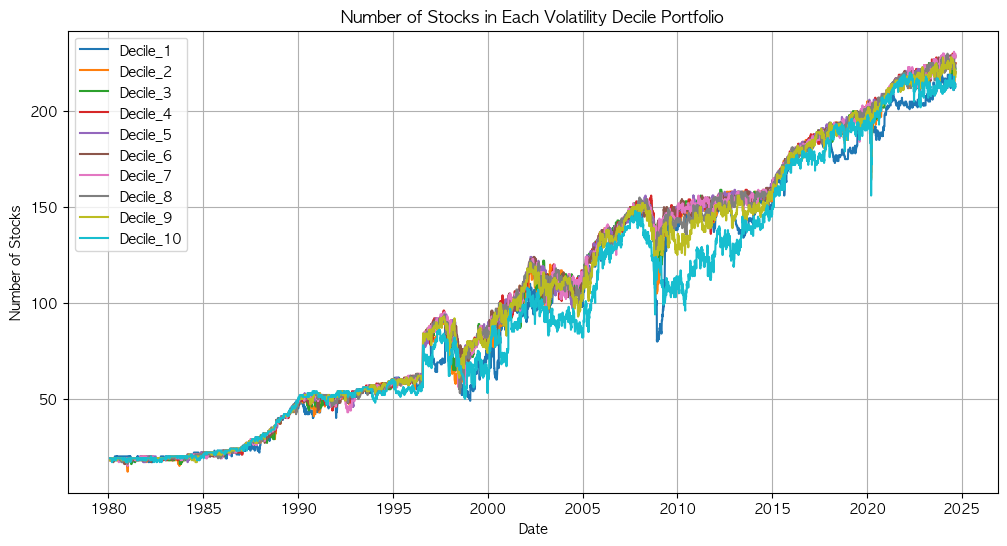


Average Portfolio Size for Each Decile:
Decile_1      97.477437
Decile_2     102.114918
Decile_3     102.545715
Decile_4     103.060364
Decile_5     103.350817
Decile_6     102.908823
Decile_7     102.842398
Decile_8     102.323876
Decile_9     101.122664
Decile_10     94.703233
dtype: float64


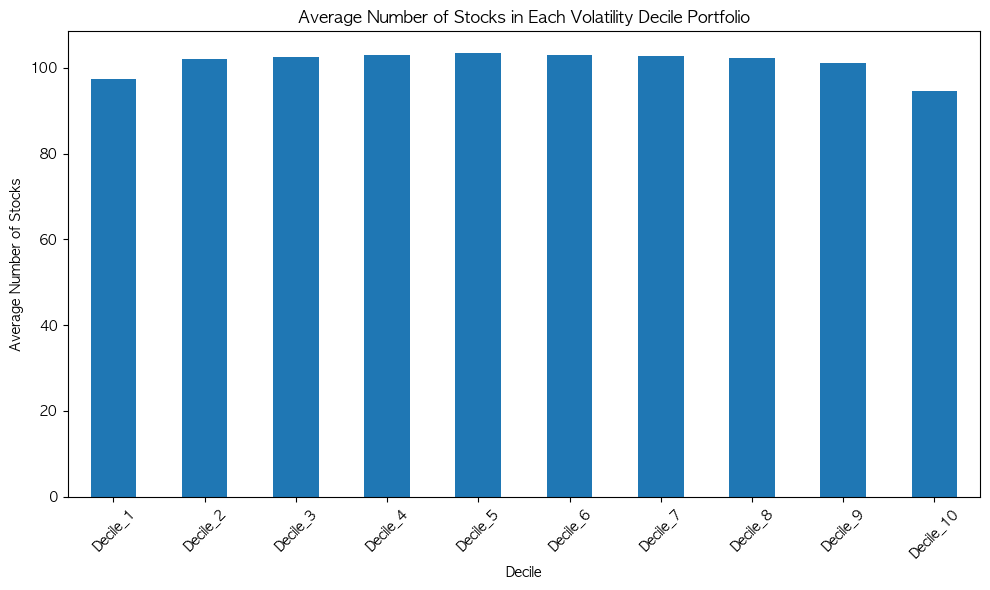

In [321]:
def get_volatility_decile_returns(returns, days):
    decile_returns_df = pd.DataFrame(index=returns.index)
    # 월말 날짜 리스트 추출
    month_ends = returns.index.to_series().resample('M').last().tolist()
    
    for i in range(1, len(month_ends)):
        rebalance_date = month_ends[i - 1]
        next_rebalance_date = month_ends[i]
        volatility_start_date = rebalance_date - pd.Timedelta(days=days)
        volatility_returns = returns.loc[volatility_start_date:rebalance_date]
        volatility = volatility_returns.std()
        sorted_volatility = volatility.sort_values()
        
        # NaN 값 제거
        sorted_volatility = sorted_volatility.dropna()
        # Volatility 0인 값 제거
        sorted_volatility = sorted_volatility[sorted_volatility > 10e-5]
        if sorted_volatility.empty:
            continue
        #print(sorted_volatility)
        deciles = pd.qcut(sorted_volatility, 10, labels=False, duplicates='drop')
        #print(deciles)
        period_returns = returns.loc[rebalance_date + pd.Timedelta(days=1):next_rebalance_date]
        
        for decile in range(10):
            decile_stocks = sorted_volatility.index[deciles == decile]
            decile_label = f'Decile_{decile + 1}'
            
            if len(decile_stocks) > 0:
                decile_portfolio_returns = period_returns[decile_stocks].mean(axis=1)
                decile_returns_df.loc[decile_portfolio_returns.index, decile_label] = decile_portfolio_returns
            else:
                # 해당 데시일에 종목이 없는 경우 0으로 채움
                decile_returns_df.loc[period_returns.index, decile_label] = 0.0
                        
    decile_returns_df = decile_returns_df.dropna(how='all')
    return decile_returns_df

# 함수 실행
decile_returns_df = get_volatility_decile_returns(returns_df, 252)
decile_returns_df


# # 결과 출력
# print("Decile Returns:")
# print(decile_returns_df.head())
# print("\nDecile Portfolio Counts:")
# print(decile_counts_df.head())

# # 데사일별 포트폴리오 종목 수 시각화
# plt.figure(figsize=(12, 6))
# for col in decile_counts_df.columns:
#     plt.plot(decile_counts_df.index, decile_counts_df[col], label=col)

# plt.title('Number of Stocks in Each Volatility Decile Portfolio')
# plt.xlabel('Date')
# plt.ylabel('Number of Stocks')
# plt.legend()
# plt.grid(True)
# plt.show()

# # 평균 포트폴리오 크기 계산
# average_portfolio_size = decile_counts_df.mean()
# print("\nAverage Portfolio Size for Each Decile:")
# print(average_portfolio_size)

# # 데사일별 평균 포트폴리오 크기 막대 그래프
# plt.figure(figsize=(10, 6))
# average_portfolio_size.plot(kind='bar')
# plt.title('Average Number of Stocks in Each Volatility Decile Portfolio')
# plt.xlabel('Decile')
# plt.ylabel('Average Number of Stocks')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

Decile Returns:
            Decile_1  Decile_2  Decile_3  Decile_4  Decile_5  Decile_6  \
Date                                                                     
1980-02-01  0.009333  0.010282 -0.008764  0.014843  0.012436 -0.000067   
1980-02-02  0.002022  0.003337 -0.005555 -0.001692 -0.003891  0.002541   
1980-02-04 -0.003104  0.000523  0.001172  0.000980 -0.001343 -0.011105   
1980-02-05  0.000093 -0.003597  0.008623 -0.001665 -0.004787 -0.005565   
1980-02-06 -0.003849  0.001635 -0.000514  0.001103 -0.001500 -0.005729   

            Decile_7  Decile_8  Decile_9  Decile_10  
Date                                                 
1980-02-01 -0.011574 -0.025791 -0.031638  -0.035951  
1980-02-02  0.005894  0.002595  0.009670   0.023913  
1980-02-04 -0.001800 -0.006199 -0.016299   0.001281  
1980-02-05 -0.008803 -0.011790 -0.013663   0.009544  
1980-02-06 -0.008542 -0.011684 -0.007868  -0.003839  

Decile Portfolio Counts:
            Decile_1  Decile_2  Decile_3  Decile_4  Decile_5 

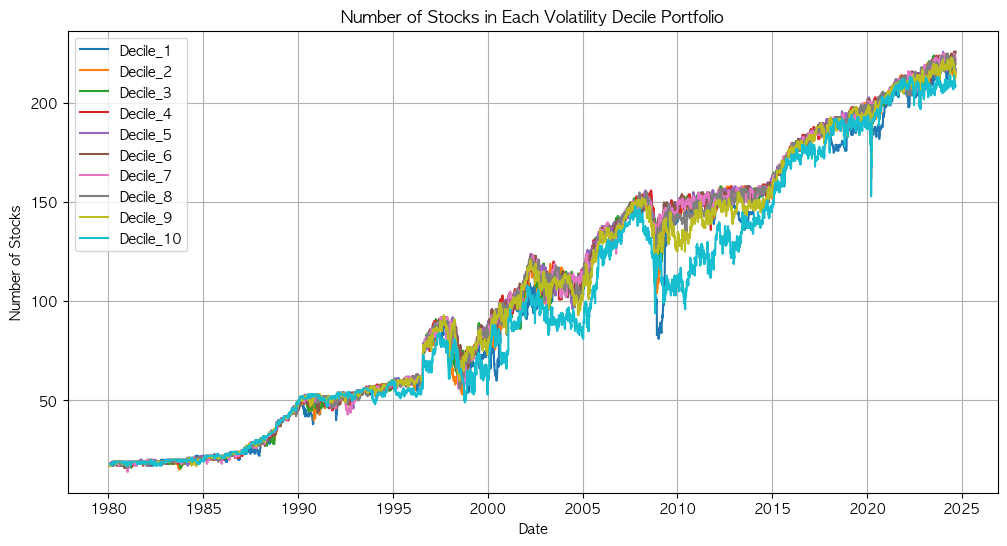


Average Portfolio Size for Each Decile:
Decile_1      98.541589
Decile_2     101.325223
Decile_3     101.698350
Decile_4     102.199276
Decile_5     102.486193
Decile_6     102.064236
Decile_7     101.951507
Decile_8     101.491076
Decile_9     100.274457
Decile_10     93.856457
dtype: float64


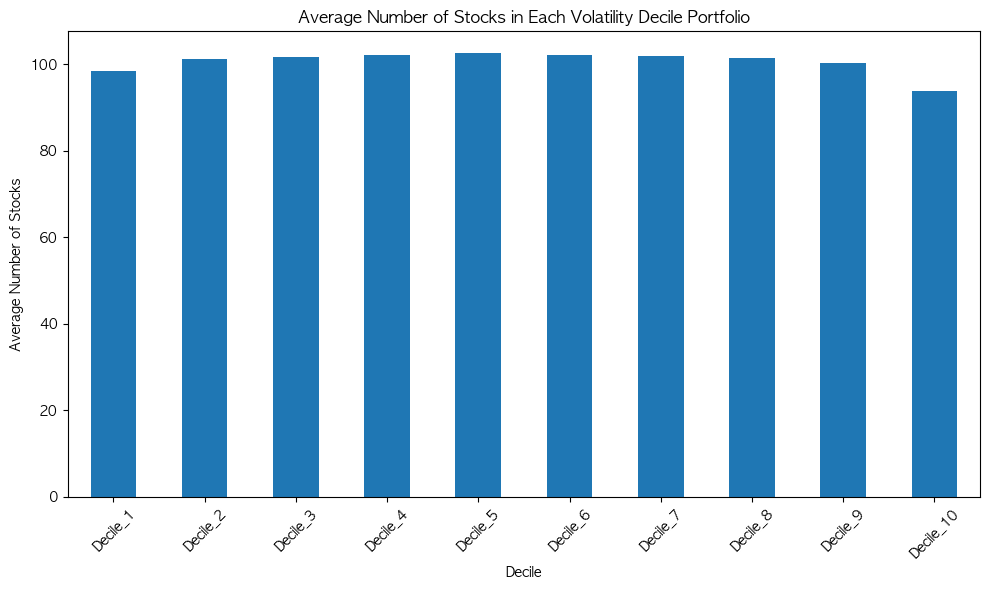

In [323]:
def get_volatility_decile_returns_and_counts(returns, days, trading_days=252):
    decile_returns_df = pd.DataFrame(index=returns.index)
    decile_counts_df = pd.DataFrame(index=returns.index)
    month_ends = returns.index.to_series().resample('M').last().tolist()
    
    for i in range(1, len(month_ends)):
        rebalance_date = month_ends[i - 1]
        next_rebalance_date = month_ends[i]
        volatility_start_date = rebalance_date - pd.Timedelta(days=days)
        
        volatility_returns = returns.loc[volatility_start_date:rebalance_date]
        
        # 연율화된 volatility 계산
        volatility = volatility_returns.std() * np.sqrt(trading_days)
        
        sorted_volatility = volatility.sort_values().dropna()
        # Volatility 0인 값 제거
        sorted_volatility = sorted_volatility[sorted_volatility > 10e-5]        
        if sorted_volatility.empty:
            continue
        
        deciles = pd.qcut(sorted_volatility, 10, labels=False, duplicates='drop')
        
        next_trading_day = returns.index[returns.index > rebalance_date][0]
        period_returns = returns.loc[next_trading_day:next_rebalance_date]
        
        for decile in range(10):
            decile_stocks = sorted_volatility.index[deciles == decile]
            decile_label = f'Decile_{decile + 1}'
            
            if len(decile_stocks) > 0:
                decile_portfolio_returns = period_returns[decile_stocks].mean(axis=1)
                decile_returns_df.loc[decile_portfolio_returns.index, decile_label] = decile_portfolio_returns
                
                # 각 날짜별로 데사일 포트폴리오의 종목 수 계산
                decile_counts = (period_returns[decile_stocks].notna().sum(axis=1))
                decile_counts_df.loc[decile_counts.index, decile_label] = decile_counts
            else:
                decile_returns_df.loc[period_returns.index, decile_label] = 0.0
                decile_counts_df.loc[period_returns.index, decile_label] = 0
    
    decile_returns_df = decile_returns_df.dropna(how='all')
    decile_counts_df = decile_counts_df.dropna(how='all')
    return decile_returns_df, decile_counts_df

# 함수 실행
decile_returns_df, decile_counts_df = get_volatility_decile_returns_and_counts(returns_df, 252)

# 결과 출력
print("Decile Returns:")
print(decile_returns_df.head())
print("\nDecile Portfolio Counts:")
print(decile_counts_df.head())

# 데사일별 포트폴리오 종목 수 시각화
plt.figure(figsize=(12, 6))
for col in decile_counts_df.columns:
    plt.plot(decile_counts_df.index, decile_counts_df[col], label=col)

plt.title('Number of Stocks in Each Volatility Decile Portfolio')
plt.xlabel('Date')
plt.ylabel('Number of Stocks')
plt.legend()
plt.grid(True)
plt.show()

# 평균 포트폴리오 크기 계산
average_portfolio_size = decile_counts_df.mean()
print("\nAverage Portfolio Size for Each Decile:")
print(average_portfolio_size)

# 데사일별 평균 포트폴리오 크기 막대 그래프
plt.figure(figsize=(10, 6))
average_portfolio_size.plot(kind='bar')
plt.title('Average Number of Stocks in Each Volatility Decile Portfolio')
plt.xlabel('Decile')
plt.ylabel('Average Number of Stocks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [324]:
(decile_returns_df+1).cumprod()

,Decile_1,Decile_2,Decile_3,Decile_4,Decile_5,Decile_6,Decile_7,Decile_8,Decile_9,Decile_10
Date,,,,,,,,,,
1980-02-01,1.009333,1.010282,0.991236,1.014843,1.012436,0.999933,0.988426,0.974209,0.968362,9.640486e-01
1980-02-02,1.011375,1.013654,0.985730,1.013126,1.008497,1.002475,0.994252,0.976737,0.977725,9.871024e-01
1980-02-04,1.008235,1.014184,0.986885,1.014119,1.007142,0.991343,0.992463,0.970682,0.961790,9.883668e-01
1980-02-05,1.008329,1.010536,0.995395,1.012431,1.002321,0.985826,0.983726,0.959237,0.948649,9.978002e-01
1980-02-06,1.004448,1.012189,0.994883,1.013548,1.000817,0.980178,0.975323,0.948030,0.941185,9.939696e-01
...,...,...,...,...,...,...,...,...,...,...
2024-08-26,39.445141,8.401444,3.017204,2.306126,0.806863,0.525161,0.139190,0.006285,0.000598,7.369176e-07
2024-08-27,39.439559,8.417559,3.015095,2.314069,0.809348,0.525512,0.139644,0.006307,0.000601,7.381962e-07
2024-08-28,39.399939,8.406484,3.001601,2.309125,0.806210,0.523026,0.138845,0.006263,0.000601,7.289007e-07


In [325]:
decile_counts_df

,Decile_1,Decile_2,Decile_3,Decile_4,Decile_5,Decile_6,Decile_7,Decile_8,Decile_9,Decile_10
Date,,,,,,,,,,
1980-02-01,18.0,18.0,17.0,17.0,18.0,18.0,17.0,18.0,17.0,18.0
1980-02-02,18.0,18.0,18.0,17.0,18.0,18.0,17.0,18.0,17.0,18.0
1980-02-04,18.0,18.0,18.0,17.0,18.0,18.0,17.0,18.0,17.0,18.0
1980-02-05,18.0,18.0,18.0,17.0,18.0,18.0,17.0,18.0,17.0,18.0
1980-02-06,18.0,18.0,18.0,17.0,18.0,18.0,17.0,18.0,17.0,18.0
...,...,...,...,...,...,...,...,...,...,...
2024-08-26,217.0,220.0,217.0,222.0,216.0,225.0,224.0,221.0,215.0,209.0
2024-08-27,217.0,220.0,217.0,222.0,217.0,225.0,224.0,220.0,216.0,209.0
2024-08-28,217.0,220.0,217.0,222.0,217.0,226.0,223.0,220.0,214.0,209.0


In [329]:
(decile_returns_df['2010':'2015']+1).cumprod()

,Decile_1,Decile_2,Decile_3,Decile_4,Decile_5,Decile_6,Decile_7,Decile_8,Decile_9,Decile_10
Date,,,,,,,,,,
2010-01-04,0.999164,1.001461,1.007053,1.016409,1.017644,1.019528,1.027000,1.028405,1.031677,1.017642
2010-01-05,0.998108,1.001848,1.012587,1.020449,1.019467,1.029625,1.034432,1.042859,1.045386,1.030577
2010-01-06,0.998155,1.005123,1.020528,1.029104,1.029524,1.038833,1.044535,1.053857,1.050090,1.034541
2010-01-07,0.995670,1.003959,1.017459,1.029437,1.024565,1.037174,1.038460,1.051177,1.043634,1.036519
2010-01-08,0.996817,1.009964,1.020806,1.038357,1.030848,1.041412,1.049535,1.058918,1.042052,1.036078
...,...,...,...,...,...,...,...,...,...,...
2015-12-23,1.834066,1.845666,1.614286,1.693172,1.359199,1.336572,1.041728,0.610037,0.520509,0.138875
2015-12-24,1.835948,1.845494,1.614974,1.697063,1.354041,1.337242,1.043971,0.608244,0.520233,0.137931
2015-12-28,1.836166,1.837117,1.605340,1.690585,1.350044,1.336062,1.038621,0.603256,0.514133,0.137576


In [330]:
initial_price = 10000
decile_price_df = (decile_returns_df+1).cumprod() * initial_price
decile_price_df

,Decile_1,Decile_2,Decile_3,Decile_4,Decile_5,Decile_6,Decile_7,Decile_8,Decile_9,Decile_10
Date,,,,,,,,,,
1980-02-01,10093.334588,10102.823362,9912.356544,10148.432880,10124.361540,9999.333426,9884.264024,9742.086540,9683.615020,9640.486041
1980-02-02,10113.745139,10136.539224,9857.297943,10131.261052,10084.966303,10024.746069,9942.524817,9767.367814,9777.254055,9871.023614
1980-02-04,10082.348499,10141.841966,9868.850649,10141.192447,10071.421051,9913.426209,9924.627350,9706.818384,9617.898105,9883.667804
1980-02-05,10083.290952,10105.363854,9953.948115,10124.310879,10023.212083,9858.262546,9837.257603,9592.371329,9486.486178,9978.001749
1980-02-06,10044.484350,10121.891138,9948.828473,10135.478435,10008.173804,9801.779690,9753.227527,9480.295609,9411.845751,9939.695646
...,...,...,...,...,...,...,...,...,...,...
2024-08-26,394451.407220,84014.443085,30172.043269,23061.257100,8068.633233,5251.611084,1391.904082,62.845568,5.982591,0.007369
2024-08-27,394395.590739,84175.591658,30150.949048,23140.693611,8093.476767,5255.120063,1396.439631,63.071403,6.013546,0.007382
2024-08-28,393999.388743,84064.839703,30016.008042,23091.246227,8062.099347,5230.255334,1388.448129,62.629126,6.006270,0.007289


In [331]:
decile_returns_df.describe()

,Decile_1,Decile_2,Decile_3,Decile_4,Decile_5,Decile_6,Decile_7,Decile_8,Decile_9,Decile_10
count,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000
mean,0.000338,0.000236,0.000168,0.000164,0.000089,0.000070,-0.000027,-0.000274,-0.000457,-0.000999
std,0.007487,0.010555,0.012220,0.013619,0.014570,0.015694,0.016598,0.017392,0.018197,0.019362
min,-0.126998,-0.145735,-0.132531,-0.143338,-0.156607,-0.150141,-0.158213,-0.152031,-0.154408,-0.154688
25%,-0.002188,-0.003562,-0.004467,-0.005096,-0.005864,-0.006452,-0.007152,-0.007808,-0.008618,-0.010188
50%,0.000480,0.000622,0.000564,0.000682,0.000709,0.000713,0.000673,0.000219,0.000148,-0.000609
75%,0.003314,0.004843,0.005757,0.006698,0.007130,0.007727,0.008249,0.008585,0.008650,0.008859
max,0.084683,0.093844,0.102369,0.114362,0.103336,0.110414,0.108297,0.108765,0.113593,0.106570


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

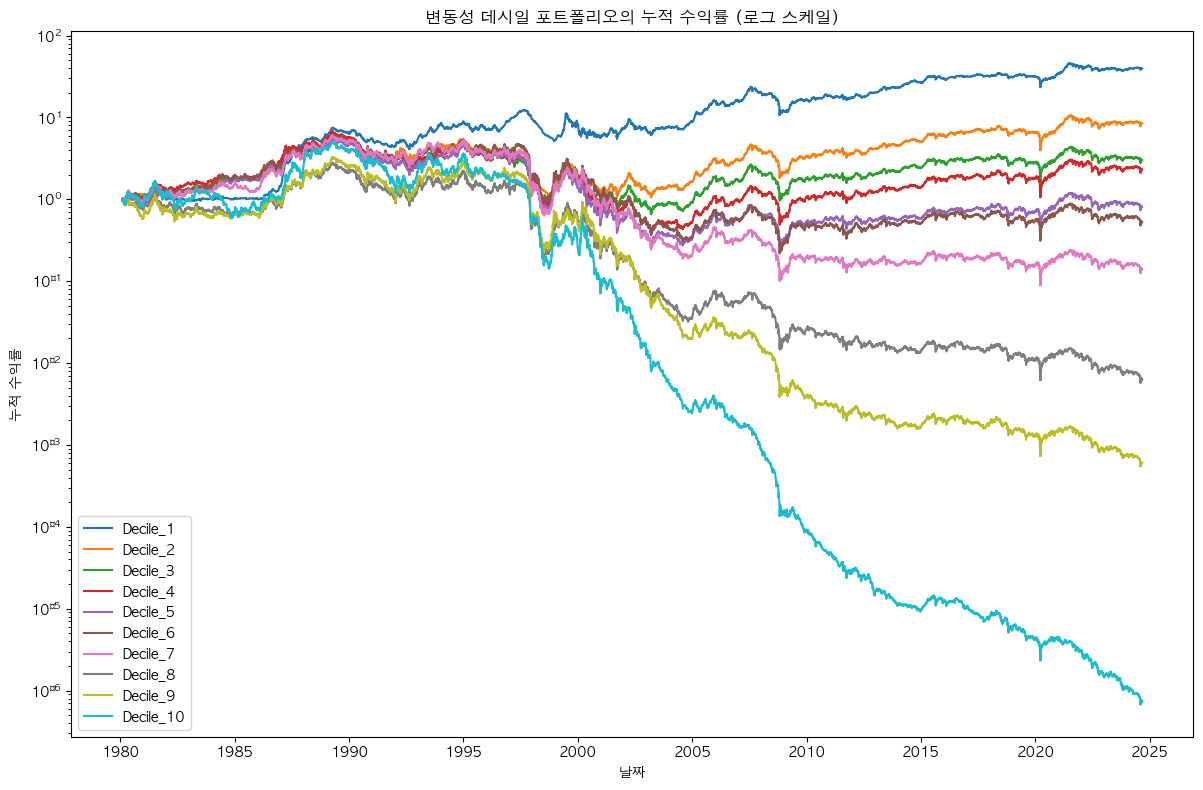

In [333]:
# 누적 수익률 계산
cumulative_decile_returns_df = (1 + decile_returns_df).cumprod()
# 그래프 스타일 설정 (선택 사항)
#plt.style.use('seaborn-darkgrid')

# 로그 스케일로 누적 수익률 그래프 그리기
plt.figure(figsize=(12, 8))

for decile in range(1, 11):
    decile_label = f'Decile_{decile}'
    plt.plot(cumulative_decile_returns_df.index, cumulative_decile_returns_df[decile_label], label=decile_label)

plt.title('변동성 데시일 포트폴리오의 누적 수익률 (로그 스케일)')
plt.xlabel('날짜')
plt.ylabel('누적 수익률')
plt.legend()
plt.tight_layout()

# y축을 로그 스케일로 설정
plt.yscale('log')

plt.show()

In [294]:
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (필요 시 주석 해제)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


# Main Code Gen Algorithm

In [451]:
class LogicalSeries(pd.Series):
    """ 아래 primitives에서 사용하기 위해 객체 선언 """
    pass

class GeneticProgrammingTrader:
    def __init__(self, price_df, factor_df, returns_df, stock_name, start_year = '1990', training_years=5, selection_years=5, out_sample_years=1, PRINT_ON = False):
        """
        초기화 메서드
        :param price_df: 주가 데이터 DataFrame
        :param factor_df: 팩터 데이터 DataFrame
        :param training_years: 학습 기간 (년)
        :param selection_years: 선택 기간 (년)
        :param out_sample_years: 외부 검증 기간 (년)
        :param days_per_year: 연도당 일수
        """
        self.padding_days = 100
        self.stock_name = stock_name
        self.PRINT_ON = PRINT_ON
        self.price_df = price_df
        self.returns_df = returns_df
        self.returns_series = []
        self.factor_df = factor_df
        self.training_years = training_years
        self.selection_years = selection_years
        self.out_sample_years = out_sample_years
        #self.days_per_year = days_per_year
        self.start_year = start_year        
        self.setup_data()
        self.setup_gp()
        
    def setup_data(self):
        """
        데이터를 학습, 선택, 외부 검증 기간으로 분할
        """
        
        # 인덱스를 datetime으로 변환 (이미 datetime인 경우 이 단계를 건너뛸 수 있습니다)
        self.price_df.index = pd.to_datetime(self.price_df.index)
        self.factor_df.index = pd.to_datetime(self.factor_df.index)


        # 특정 주식 데이터만 선택
        stock_price = self.price_df[self.stock_name]
        self.returns_series = self.returns_df[self.stock_name]
        # 전체 기간의 시작과 끝 년도 확인
        training_start_year = pd.to_datetime(self.start_year).year
        end_year = stock_price.index[-1].year

        # 기간 분할
        training_end_year = training_start_year + self.training_years
        selection_end_year = training_end_year + self.selection_years
        out_sample_end_year = selection_end_year + self.out_sample_years

        # 데이터 분할
        self.training_df = stock_price[(stock_price.index.year < training_end_year) &
                                       (stock_price.index.year >= training_start_year)]
        self.selection_df = stock_price[(stock_price.index.year >= training_end_year) & 
                                        (stock_price.index.year < selection_end_year)]
        self.out_sample_df = stock_price[(stock_price.index.year >= selection_end_year) & 
                                         (stock_price.index.year < out_sample_end_year)]

        # 팩터 데이터 분할
        self.training_factors = self.factor_df[self.factor_df.index.year < training_end_year]
        self.selection_factors = self.factor_df[(self.factor_df.index.year >= training_end_year) & 
                                                (self.factor_df.index.year < selection_end_year)]
        self.out_sample_factors = self.factor_df[(self.factor_df.index.year >= selection_end_year) & 
                                                 (self.factor_df.index.year < out_sample_end_year)]

        # 학습 및 선택 기간을 결합하여 GP 진화에 사용
        self.combined_price = pd.concat([self.training_df, self.selection_df])
        self.combined_factors = pd.concat([self.training_factors, self.selection_factors])

        # 패딩 추가
        training_start = self.training_df.index[0] - pd.Timedelta(days=self.padding_days)
        selection_start = self.selection_df.index[0] - pd.Timedelta(days=self.padding_days)
        out_sample_start = self.out_sample_df.index[0] - pd.Timedelta(days=self.padding_days)
        
        self.training_df_padded = stock_price.loc[training_start:self.training_df.index[-1]]
        self.selection_df_padded = stock_price.loc[selection_start:self.selection_df.index[-1]]
        self.out_sample_df_padded = stock_price.loc[out_sample_start:self.out_sample_df.index[-1]]

        # 팩터 데이터에도 패딩 적용
        self.training_factors_padded = self.factor_df.loc[training_start:self.training_factors.index[-1]]
        self.selection_factors_padded = self.factor_df.loc[selection_start:self.selection_factors.index[-1]]
        self.out_sample_factors_padded = self.factor_df.loc[out_sample_start:self.out_sample_factors.index[-1]]



        total_used_years = self.training_years + self.selection_years + self.out_sample_years
        # 데이터 정보 출력
        if self.PRINT_ON:
            print(f"Training period: {self.training_df.index[0]} to {self.training_df.index[-1]}")
            print(f"Selection period: {self.selection_df.index[0]} to {self.selection_df.index[-1]}")
            print(f"OS period: {self.out_sample_df.index[0]} to {self.out_sample_df.index[-1]}")        
            print(f"\nTotal years used: {total_used_years}")

    def setup_gp(self):
        """
        GP 프리미티브 및 DEAP 툴박스 설정
        """
        # 3-2. 연산자 및 터미널 집합 정의 (타이핑된 GP 사용)
        # 입력 타입: pd.Series, int; 출력 타입: pd.Series
        self.pset = gp.PrimitiveSetTyped("MAIN", [pd.Series, pd.Series], pd.Series)
        self.pset.renameArguments(ARG0='price', ARG1 = 'returns')
        
        # Level 1: Boolean operators and functions
        def if_then_else(condition):
            return pd.Series(np.where(condition > 0, 1, 0), index=condition.index)

        def and_op(a, b):
            return pd.Series(np.logical_and(a > 0, b > 0).astype(float), index=a.index)
        
        def or_op(a, b):
            return pd.Series(np.logical_or(a > 0, b > 0).astype(float), index=a.index)

        # self.pset.addPrimitive(if_then_else, [pd.Series], pd.Series, name="if_then_else")
        # self.pset.addPrimitive(and_op, [pd.Series, pd.Series], pd.Series, name="and_op")
        # self.pset.addPrimitive(or_op, [pd.Series, pd.Series], pd.Series, name="or_op")
        self.pset.addPrimitive(if_then_else, [LogicalSeries], LogicalSeries, name="if_then_else")
        self.pset.addPrimitive(and_op, [LogicalSeries, LogicalSeries], LogicalSeries, name="and_op")
        self.pset.addPrimitive(or_op, [LogicalSeries, LogicalSeries], LogicalSeries, name="or_op")        
        # Level 2: Relational operators
        def greater_than(series1, series2):
            return pd.Series((series1 > series2).astype(float), index=series1.index)
        
        def less_than(series1, series2):
            return pd.Series((series1 < series2).astype(float), index=series1.index)
        
        #self.pset.addPrimitive(greater_than, [pd.Series, pd.Series], pd.Series, name="greater_than")
        #self.pset.addPrimitive(less_than, [pd.Series, pd.Series], pd.Series, name="less_than")
        self.pset.addPrimitive(greater_than, [pd.Series, pd.Series], LogicalSeries, name="greater_than")
        self.pset.addPrimitive(less_than, [pd.Series, pd.Series], LogicalSeries, name="less_than")        
        # Level 3: Real functions
        def avg(series, days):
            return series.rolling(window=int(days)).mean()
        
        def max_func(series, days):
            return series.rolling(window=int(days)).max()
        
        def min_func(series, days):
            return series.rolling(window=int(days)).min()
        
        def median(series, days):
            return series.rolling(window=int(days)).median()
        
        def lag(series, days):
            return series.shift(int(days))
        
        def volatility(series, days):
            """ days 동안의 volatility 를 연율화하여 100%로 표현 """
            vol = series.rolling(window=int(days)).std()
            annual_vol = vol * np.sqrt(252 / days) * 100
            return annual_vol
        
        def rsi(series, period):
            delta = series.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
            rs = gain / loss
            rsi = 100 - (100 / (1 + rs))
            return rsi
        
        def filter_func(price, days, pr):
            lagged_price = price.shift(int(days))
            filter_price = lagged_price * (1 + pr)
            return pd.Series(price > filter_price, index=price.index).astype(float)

        self.pset.addPrimitive(filter_func, [pd.Series, int, float], pd.Series, name="Filter")
        self.pset.addPrimitive(avg, [pd.Series, int], pd.Series, name="Avg")
        self.pset.addPrimitive(max_func, [pd.Series, int], pd.Series, name="Max")
        self.pset.addPrimitive(min_func, [pd.Series, int], pd.Series, name="Min")
        self.pset.addPrimitive(median, [pd.Series, int], pd.Series, name="Median")
        self.pset.addPrimitive(lag, [pd.Series, int], pd.Series, name="Lag")
        self.pset.addPrimitive(volatility, [pd.Series, int], pd.Series, name="Volatility")
        self.pset.addPrimitive(rsi, [pd.Series, int], pd.Series, name="RSI")

        def get_int_constant():
            return random.randint(1, 100)

        self.pset.addPrimitive(get_int_constant, [], int)#, name="get_int_constant")
                
        #for i in range(1, 101):
        #    self.pset.addTerminal(i, int)
        # Pr 터미널 추가 (1과 -1 사이의 랜덤 값)
        #self.pset.addEphemeralConstant("rand_pr", lambda: random.uniform(-1, 1), float)
        
        # 터미널 추가 (price와 returns 모두 사용 가능하도록)
        self.pset.addTerminal('price', pd.Series)
        self.pset.addTerminal('returns', pd.Series)
        
        # DEAP 설정
        creator.create('FitnessMax', base.Fitness, weights=(1.0,))
        creator.create('Individual', list, fitness=creator.FitnessMax)
        
        self.toolbox = base.Toolbox()
        def generate_tree():
            # 루트 노드 프리미티브만 선택
            root_primitives = [p for p in self.pset.primitives[pd.Series] if p.name in ["if_then_else", "and_op", "or_op"]]
            root = random.choice(root_primitives)
            if root.name == "if_then_else":
                # arity=1
                return [root] + generate_subtree(2)#, is_comparison=True)
            else: # and_op, or_op
                # arity=2
                #return [root] + generate_subtree(2, is_comparison=True) + generate_subtree(2, is_comparison=True)
                return [root] + generate_subtree(2) + generate_subtree(2)

        def generate_subtree(level):#, is_comparison=False):
            if level == 2:# or is_comparison:
                # 비교 연산자 프리미티브 선택
                comp_primitives = [p for p in self.pset.primitives[pd.Series] if p.name in ["greater_than", "less_than"]]
                if not comp_primitives:
                    raise ValueError("No comparison primitives available.")
                comp = random.choice(comp_primitives)
                # arity=2 (series, float)
                # 오른쪽 항은 real var 오게 바꿔줌
                #return [comp] + generate_subtree(3, is_comparison=False) + generate_subtree(5)   # is_comparison=False to prevent infinite recursion
                return [comp] + generate_subtree(3) + generate_subtree(6)   # is_comparison=False to prevent infinite recursion
            elif level == 3:
                # 실수 함수 프리미티브 선택
                func_primitives = [p for p in self.pset.primitives[pd.Series] if p.name in ["Avg", "Max", "Min", "Median", "Lag", "Volatility", "RSI", "Filter"]]
                if not func_primitives:
                    raise ValueError("No function primitives available.")
                func = random.choice(func_primitives)
                # arity=2 (series, int)
                random_float = round(random.uniform(-1, 1), 3)
                # Filter 함수는 Pr 고려해줌
                if func.name == "Filter": 
                    return [func] + generate_subtree(5) + generate_subtree(4) + [gp.Terminal(random_float, float, float)]
                else:
                    return [func] + generate_subtree(5) + generate_subtree(4)
            elif level == 4:
                # 터미널: 정수 상수만
                return [gp.Terminal(random.randint(1, 100), int, int)]
            elif level == 5:
                # 터미널: price or returns
                return [gp.Terminal(random.choice(['price', 'returns']), pd.Series, pd.Series)]
            elif level == 6:
                # 터미널: price or returns or int or float
                #return [gp.Terminal('price', pd.Series, pd.Series)]
                rand = random.uniform(0, 1)
                if rand < 0.5:
                    return [gp.Terminal(random.choice(['price', 'returns']), pd.Series, pd.Series)]
                elif rand < 0.75:
                    # 0.0 ~ 1.0 사이 float gen
                    pos_random_float = round(random.uniform(0, 1), 3)
                    return [gp.Terminal(pos_random_float, float, float)]
                else:
                    # 1 ~ 100 사이 숫자 gen
                    return [gp.Terminal(random.randint(1, 100), int, int)]
                #return [gp.Terminal(self.pset.terminals[pd.Series][0], pd.Series, pd.Series)]                
            else:
                raise ValueError(f"Invalid level: {level}")
                       
        # 개별 트리 생성기 등록
        self.toolbox.register('expr_buy', generate_tree)#, pset=self.pset, min_=1, max_=3)
        self.toolbox.register('expr_sell', generate_tree)#, pset=self.pset, min_=1, max_=3)
        
        def create_individual():
            buy_expr = self.toolbox.expr_buy()
            sell_expr = self.toolbox.expr_sell()
            
            # buy_expr과 sell_expr이 이미 PrimitiveTree인지 확인
            if not isinstance(buy_expr, gp.PrimitiveTree):
                buy_expr = gp.PrimitiveTree(buy_expr)
            if not isinstance(sell_expr, gp.PrimitiveTree):
                sell_expr = gp.PrimitiveTree(sell_expr)
            
            return creator.Individual([buy_expr, sell_expr])        
        self.toolbox.register('individual', create_individual)
        self.toolbox.register('population', tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register('compile', gp.compile, pset=self.pset)

        # 'mate' 등록
        self.toolbox.register('mate', gp.cxOnePoint)
        
        #self.toolbox.register('select', tools.selTournament, tournsize=3)
        
        # 'expr_mut'를 먼저 등록해야 합니다.
        #self.toolbox.register('expr_mut', gp.genFull, pset=self.pset, min_=0, max_=2)
        
        # # 'mutate' 등록
        # self.toolbox.register('mutate', gp.mutUniform, expr=self.toolbox.expr_mut, pset=self.pset)
        

        
        # **프리미티브 등록 상태 확인 (디버깅 용)**
        # print("Primitives by type after setup_gp:")
        # for typ, prims in self.pset.primitives.items():
        #     prim_names = []
        #     for p in prims:
        #         if hasattr(p, 'name'):
        #             prim_names.append(p.name)
        #         elif hasattr(p, 'value'):
        #             prim_names.append(str(p.value))
        #         else:
        #             prim_names.append(str(p))
        #     print(f"Type {typ}: {prim_names}")
    

    def evaluate_strategy(self, individual, price_series, factor_df, train_type, transaction_cost=0.001):
        buy_expr, sell_expr = individual
        buy_func = self.toolbox.compile(expr=buy_expr)
        sell_func = self.toolbox.compile(expr=sell_expr)
        returns_series = self.returns_series[price_series.index]
        try:
            # 패딩된 데이터로 시그널 생성        
            buy_signal = buy_func(price_series, returns_series)
            sell_signal = sell_func(price_series, returns_series)
                      
            # 원래 기간의 데이터만 선택 (패딩 제거)
            original_period = price_series.loc[price_series.index[self.padding_days:]].index
            buy_signal = buy_signal.loc[original_period]
            sell_signal = sell_signal.loc[original_period]
            price_series = price_series.loc[original_period]
            factor_df = factor_df.loc[original_period]            
            
            combined_signal = pd.Series(0, index=price_series.index)
            buy_only = (buy_signal > 0) & (sell_signal <= 0)
            combined_signal[buy_only] = 1
            sell_only = (sell_signal > 0) & (buy_signal <= 0)
            combined_signal[sell_only] = -1
            
            
            returns = price_series.pct_change().dropna()
            risk_free_returns = factor_df['RF'].loc[returns.index]
            combined_signal = combined_signal.shift(1).dropna()
            returns = returns.loc[combined_signal.index]
            #risk_free_returns = risk_free_returns.loc[combined_signal.index]
            
            if len(combined_signal) != len(returns):
                raise ValueError(f"Signal length {len(combined_signal)} does not match returns length {len(returns)}.")
            
            strategy_returns = pd.Series(index=returns.index)
            strategy_returns[combined_signal == 1] = returns[combined_signal == 1]
            strategy_returns[combined_signal == -1] = -returns[combined_signal == -1]
            strategy_returns[combined_signal == 0] = risk_free_returns[combined_signal == 0]            
            

            # 거래 횟수 계산
            trades = combined_signal.diff().abs()
            num_trades = trades.sum()            
            
            
            factors = factor_df.loc[strategy_returns.index]
            factors = factors.dropna()
            
            if factors.empty or strategy_returns.empty:
                raise ValueError("Either factors or strategy returns are empty after alignment.")
            
            strategy_returns = strategy_returns.loc[factors.index]
            
            X = factors[['RMRF', 'SMB', 'HML', 'MOM']]
            # 수정 -> zero portfolio
            y = strategy_returns - returns
            y = y.loc[strategy_returns.index]

            X = add_constant(X)
            # OLS 에서 Newey-West 표준 오차로 변경함
            nw_lag = 5
            model = OLS(y, X).fit(cov_type = 'HAC', cov_kwds = {'maxlags': nw_lag})
            alpha = model.params['const']
            t_stat = model.tvalues['const']
            p_value = model.pvalues['const']
            
            sharpe_ratio = np.sqrt(252) * (strategy_returns - risk_free_returns).mean() / strategy_returns.std()
            total_return = (1 + strategy_returns).prod() - 1
            holding_total_return = (1 + returns).prod() - 1
            alpha = alpha * 252 # yearly로 변경
            

            
            if train_type == "OS":
                # 4 Factor alpha OLS
                X2 = factors[['RMRF', 'SMB', 'HML', 'MOM']]
                y2 = strategy_returns - risk_free_returns
                X2 = add_constant(X)
                model2 = OLS(y2, X2).fit()
                ff_alpha = model2.params['const']
                ff_alpha = ff_alpha * 252 
            else:
                ff_alpha = -np.inf
            # BETC 계산
            #total_profit = (strategy_returns + 1).prod() - 1
            betc = (total_return + 1) ** (1 / num_trades) - 1 if num_trades > 0 else 0
            #(1+betc) ** (num_trades) = total_return
            
            # Buy, Sell 개수 계산
            buy_num, sell_num, hold_rf_num = self.count_signals(combined_signal)

            
            if p_value < 0.1 and alpha > 0 and betc > 0.0025: # BETC > 25bps
                fitness = alpha
            else:
                fitness = -np.inf       
            # Fitness 할당은 OS가 아닐 때에만 갱신해줌
            #if not is_os: 
            #    individual.fitness.values = (fitness,)
            # Fitness는 train일 때만 갱신
            if train_type == "Training":
                individual.fitness.values = (fitness,)
            elif train_type == "Selection":
                individual.validation_fitness = (fitness,)
            elif train_type == "OS":
                individual.out_sample_fitness = (fitness,)
            else:
                print(f"Unvalid train_type: {train_type}")
            return  {
                'alpha': alpha,
                '4factor_alpha': ff_alpha,
                'fitness': fitness,
                't_stat': t_stat,
                'betc': betc,
                'sharpe_ratio': sharpe_ratio,
                'total_return': total_return,
                'strategy_returns': strategy_returns,
                'holding_returns': returns,
                'holding_total_return': holding_total_return,
                'buy_signal': buy_signal,
                'sell_signal': sell_signal,
                'buy_num': buy_num,
                'sell_num': sell_num,
                'hold_rf_num': hold_rf_num,
                'buy_expr': str(buy_expr),
                'sell_expr': str(sell_expr)
            }
       
            # if t_stat > 2:
            #     return alpha, t_stat, sharpe_ratio, total_return, strategy_returns, buy_signal, sell_signal
            # else:
            #     return -np.inf,
            
        except Exception as e:
            print(f"Exception occurred: {e}, buy expression: {buy_expr}, sell expression: {sell_expr}")
            return None

    def count_signals(self, combined_signal):
        buy_num = 0
        sell_num = 0
        hold_rf_num = 0
        previous_signal = 0
        
        for signal in combined_signal:
            if signal != previous_signal:
                if signal == 1:
                    buy_num += 1
                elif signal == -1:
                    sell_num += 1
                elif signal == 0 and previous_signal != 0:
                    hold_rf_num += 1
            previous_signal = signal
        
        return buy_num, sell_num, hold_rf_num

    def evaluate_and_visualize(self, individual):
        if not hasattr(self, 'best_individual'):
            raise AttributeError("먼저 유전 알고리즘을 실행하여 최고 개체를 선택해야 합니다.")
        
        periods = {
            'Training': (self.training_df_padded, self.training_factors_padded),
            'Selection': (self.selection_df_padded, self.selection_factors_padded),
            'OS': (self.out_sample_df_padded, self.out_sample_factors_padded)
        }

        results = {}

        for period_name, (price_series, factor_df) in periods.items():
            # if period_name == "OS":
            #     is_os = True
            # else:
            #     is_os = False
            result = self.evaluate_strategy(individual, price_series, factor_df, train_type=period_name)
            if result is not None:
                results[period_name] = result
       
        # 결과 출력
        for period_name, result in results.items():
            print(f"\n{period_name} Period Results:")
            print(f"Alpha: {result['alpha']:.6f}")
            print(f"t-statistic: {result['t_stat']:.4f}")
            print(f"BETC: {result['betc']:.4f}")
            print(f"Sharpe Ratio: {result['sharpe_ratio']:.4f}")
            print(f"Total Return: {result['total_return']:.4f}")
            print(f"Holding Return: {result['holding_total_return']:.4f}")

        
        # 누적 수익률 시각화
        plt.figure(figsize=(15, 10))
        for period_name, result in results.items():
            plt.plot(result['strategy_returns'].index, np.log((1 + result['strategy_returns']).cumprod()), label=f'{period_name} Strategy')
            plt.plot(result['holding_returns'].index, np.log((1 + result['holding_returns']).cumprod()), label=f'{period_name} Market')

        plt.legend()
        plt.title('Log Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Log Cumulative Return')
        plt.show()
      
        buy_expr, sell_expr = individual
        self.plot_tree(buy_expr, "Buy Expression")
        self.plot_tree(sell_expr, "Sell Expression")

    def evaluate_population(self, population, price_series, factor_df, train_type):#, is_os, is_sel):
        results = []
        for i, ind in enumerate(population):
            # Train의 경우, 이미 fitness에 값이 있으면 진행하지 않음.
            # Validation은 그냥 진행함
            if not ind.fitness.valid and train_type == "Training":
                result = self.evaluate_strategy(ind, price_series, factor_df, train_type)
                results.append(result)
            elif train_type == "Selection" and not hasattr(ind, 'validation_fitness'):
                result = self.evaluate_strategy(ind, price_series, factor_df, train_type)
                results.append(result)
            elif train_type == "OS":
                result = self.evaluate_strategy(ind, price_series, factor_df, train_type)
                results.append(result)                
            # Selection 기간이면 다시 validation
            # if is_sel:
            #     result = self.evaluate_strategy(ind, price_series, factor_df, is_os)
            #     results.append(result)
            # # 아니면 값이 없을 때만 하기
            # else:
            #     if not ind.fitness.valid:
            #         result = self.evaluate_strategy(ind, price_series, factor_df, is_os)
            #         results.append(result)
                # if result is not None:
                #     #ind.fitness.values = (result['fitness'],)
                #     print(f"Individual {i}: Fitness = {ind.fitness.values[0]}")  # 디버깅용 출력
                    
                # else:
                #     #ind.fitness.values = (-np.inf,)
                #     print(f"Individual {i}: Evaluation failed")  # 디버깅용 출력

    def create_primary_set(self, size):
        return [self.toolbox.individual() for _ in range(size)]
    
    
    def run_evolution(self, population_size, generations):
        # # Create primary set
        # population = self.create_primary_set(population_size)
        # final_set = []
        # self.evaluate_population(population, self.training_df_padded, self.training_factors_padded, "Training")
        # self.evaluate_population(population, self.selection_df_padded, self.selection_factors_padded, "Selection")
        # Step 1
        current_population = self.create_primary_set(population_size)
        self.evaluate_population(current_population, self.training_df_padded, self.training_factors_padded, "Training")
        
        # Step 2
        self.evaluate_population(current_population, self.selection_df_padded, self.selection_factors_padded, "Selection")
        final_set = sorted(current_population, key=lambda ind: ind.validation_fitness[0], reverse=True)[:population_size]
    
        
        #self.PRINT_ON = True
        if self.PRINT_ON:
            print(f"{self.stock_name}")
            print(f"-- 세대 0 --")
            # 인구 다양성 체크
            unique_fitness = set(ind.fitness.values[0] for ind in current_population)
            print(f"Unique fitness numbers: {len(unique_fitness)}")            

        for gen in range(1, generations + 1):
            # Evaluate population in training period

            #self.evaluate_population(population, self.training_df_padded, self.training_factors, is_os = False, is_sel= False)
            # 개체 출력
            if self.PRINT_ON:
                print(f"-- 세대 {gen} --")
            # Step 3
            # Crossover
            offspring1 = self.apply_crossover(current_population)
            # Mutation
            offspring2 = self.apply_mutation(current_population, population_size // 2)
            # Generate random individual rules
            offspring3 = self.apply_mutation_new_rule(population_size // 2)
            
            new_offspring = offspring1 + offspring2 + offspring3
            
            # Evaluate new rules in training period
            self.evaluate_population(new_offspring, self.training_df_padded, self.training_factors_padded, "Training")
            
            # Add new rules to Current Population and select |POP| fittest
            all_individuals = current_population + new_offspring
            current_population = sorted(all_individuals, key=lambda ind: ind.fitness.values[0], reverse=True)#[:population_size]
            # 중복 제거 (2차) 및 상위 규칙 선택
            #current_population = self.remove_duplicates(current_population)[:population_size]
            self.evaluate_population(current_population, self.selection_df_padded, self.selection_factors_padded, "Selection")
            current_population = self.remove_duplicate_fitness(current_population)[:population_size]
            
            #current_population = sorted(current_population, key=lambda ind: ind.fitness.values[0], reverse=True)[:population_size]
            # Step 4
            # Evaluate new rules in selection period
            #new_individuals = [ind for ind in current_population if not hasattr(ind, 'validation_fitness')]
            #self.evaluate_population(new_individuals, self.selection_df_padded, self.selection_factors_padded, "Selection")
            
            # Add them to the best rules in the Final Set
            #final_set.extend(new_individuals)
            
            # Sort Final Set based on selection period fitness and select |POP| fittest
            #final_set = self.remove_duplicates(final_set + new_individuals)
            
            final_set = self.remove_duplicate_fitness(final_set + current_population)
            # -np.inf인 애 있으면 제거해버리기
            valid_final_set = [ind for ind in final_set if hasattr(ind, 'validation_fitness') and ind.validation_fitness[0] != -np.inf]
            final_set = sorted(valid_final_set, key=lambda ind: ind.validation_fitness[0], reverse=True)[:population_size]
            # final_set = sorted(final_set, key=lambda ind: ind.validation_fitness[0], reverse=True)[:population_size]
            if self.PRINT_ON:
                unique_fitness = set(ind.fitness.values[0] for ind in final_set)
                print(f"Unique fitness numbers: {len(unique_fitness)}")            
                self.summarize_population(final_set, top=5)

            # # Generate new populations
            # offspring1 = self.apply_crossover(population) # POP개 생성 
            # offspring2 = self.apply_mutation(population, population_size // 2) # POP/2개 기존+신규 crossover 돌연변이 생성
            # offspring3 = self.apply_mutation_new_rule(population_size // 2) # POP/2개 새로운 규칙 생성
            # #print(len(offspring1), len(offspring2), len(offspring3))
            # # Merge populations
            # new_offspring = offspring1 + offspring2 + offspring3
        
            # # 새로운 offspring만 평가
            # self.evaluate_population(new_offspring, self.training_df_padded, self.training_factors_padded, "Training")
        
            # all_individuals = population + new_offspring

            # unique_population = self.remove_duplicates(all_individuals)
            # if self.PRINT_ON:
            #     print(f"all_individuals_num: {all_individuals}, unique_population_num: {unique_population}")
            # # 부족한 인구 새로 생성 및 평가
            # while len(unique_population) < population_size:
            #     new_individual = self.toolbox.individual()
            #     self.evaluate_population([new_individual], self.training_df_padded, self.training_factors_padded, "Training")
            #     if self.is_unique(new_individual, unique_population):
            #         unique_population.append(new_individual)
            
            # # 최종 선택 (Training fitness 기준)
            # population = sorted(unique_population, key=lambda ind: ind.fitness.values[0], reverse=True)[:population_size]
            
            # # Selection 기간 평가 (새로운 개체만)
            # new_individuals = [ind for ind in population if not hasattr(ind, 'validation_fitness')]
            # self.evaluate_population(new_individuals, self.selection_df_padded, self.selection_factors_padded, "Selection")
            
            # # Selection fitness 기준으로 정렬
            # population = sorted(population, key=lambda ind: ind.validation_fitness[0], reverse=True)[:population_size]
            
            
            # new_offspring = offspring1 + offspring2 + offspring3
            
            # all_offspring = population + offspring1 + offspring2 + offspring3
            
            # # Evaluate all offspring
            # self.evaluate_population(all_offspring, self.training_df_padded, self.training_factors_padded, "Training")
            # # Select best individuals for next generation
            # population = sorted(all_offspring, key=lambda ind: ind.fitness.values[0], reverse=True)[:population_size]
            # # Evaluate best individuals in selection period
            # self.evaluate_population(population, self.selection_df_padded, self.selection_factors_padded, "Selection")
            # # Population Update
            # population = sorted(population, key=lambda ind: ind.validation_fitness[0], reverse=True)[:population_size]
            

            # 인구 다양성 체크
            # if self.PRINT_ON:
            #     unique_fitness = set(ind.fitness.values[0] for ind in population)
            #     print(f"Unique fitness numbers: {len(unique_fitness)}")            
            #     self.summarize_population(population, top=5)
        # Evaluate final results (out-of-sample)
        
        final_results = self.evaluate_final_results(final_set)
        self.best_individual = final_set[0]
        return final_set, final_results            
        # # 마지막에 저장
        # final_results = self.evaluate_final_results(population)
        # # Update Final Set
        # final_set.extend(population)
        # #final_set = sorted(final_set, key=lambda ind: ind.fitness.values[0], reverse=True)[:population_size]
        # final_set = sorted(final_set, key=lambda ind: ind.fitness.values[0], reverse=True)[:population_size]
            
        # self.best_individual = final_set[0]
        # return final_set, final_results
    
    def generate_new_individuals(self, n):
        return [self.toolbox.individual() for _ in range(n)]

    def remove_duplicate_fitness(self, population):
        unique_individuals = []
        seen_fitness = set()
        for ind in population:
            # Training fitness와 Selection fitness를 모두 고려
            fitness_key = (ind.fitness.values[0], ind.validation_fitness[0])
            if fitness_key not in seen_fitness:
                unique_individuals.append(ind)
                seen_fitness.add(fitness_key)
        return unique_individuals


    def remove_duplicates(self, population):
        unique_individuals = []
        seen = set()
        for ind in population:
            ind_hash = hash(str(ind[0]) + str(ind[1]))  # 간단한 해시 함수
            if ind_hash not in seen:
                unique_individuals.append(ind)
                seen.add(ind_hash)
        return unique_individuals
    
    def evaluate_final_results(self, population):
        """
        현재 인구의 상위 개체들을 요약하는 메서드
        :param population: 인구 리스트
        :param top: 요약할 상위 개체 수
        """
        results = []
        #top_inds = tools.selBest(population)
        for i, ind in enumerate(population, 1):
            buy_tree = ind[0]
            sell_tree = ind[1]
            #fitness = ind.fitness.values
            #result_training = self.evaluate_strategy(ind, self.training_df_padded, self.training_factors_padded, is_os = False)
            #result_selection = self.evaluate_strategy(ind, self.selection_df_padded, self.selection_factors_padded, is_os = False)
            result_out_sample = self.evaluate_strategy(ind, self.out_sample_df_padded, self.out_sample_factors_padded, "OS")
            #print(f"{i}. Buy: {buy_tree}, Sell: {sell_tree}, Fitness: {fitness[0]}, Training Fitness: {result_training['fitness']}, #Selection Fitness: {result_selection['fitness']}, Out of Sample Alpha: {result_out_sample['alpha']}")
            results.append(result_out_sample)
        results = pd.DataFrame(results)
        return results
    
    def apply_crossover(self, population):
        offspring = []
        for _ in range(len(population) // 2):
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = self.crossover(parent1, parent2)
            offspring.extend([child1, child2])
        return offspring
    
    # crossover 함수
    def crossover(self, ind1, ind2):
        if len(ind1) != 2 or len(ind2) != 2:
            raise ValueError("Individuals must have buy and sell expressions")
        ind1_copy = copy.deepcopy(ind1)
        ind2_copy = copy.deepcopy(ind2)
        #side = random.choice([0, 1])   
        #print(f"Before crossover - Ind1: {ind1_copy[0]}, {ind1_copy[1]}, Ind2: {ind2_copy[0]}, {ind2_copy[1]}")  # 디버깅용 출력
        
        self.toolbox.mate(ind1_copy[0], ind2_copy[1]) # buy, sell side 알아서 교환?
        #print(f"After crossover - Ind1: {ind1_copy[0]}, {ind1_copy[1]}, Ind2: {ind2_copy[0]}, {ind2_copy[1]}")  # 디버깅용 출력
        
        # Randomly select buy or sell side
        # Perform crossover on the selected side
        #self.toolbox.mate(ind1[side], ind2[side])
        new_ind1 = creator.Individual([ind1_copy[0], ind1_copy[1]])
        new_ind2 = creator.Individual([ind2_copy[0], ind2_copy[1]])
        #return ind1_copy, ind2_copy   
        return new_ind1, new_ind2   

    # 서브 트리 전체를 교환하는 것으로 변경함
    # def crossover(self, ind1, ind2):
    # # 50% 확률로 buy 트리를 교환, 아니면 sell 트리를 교환
    #     if random.random() < 0.5:
    #         # buy 트리 교환
    #         new_ind1_buy_tree = ind2[0]
    #         new_ind2_buy_tree = ind1[0]
    #         new_ind1_sell_tree = ind1[1]
    #         new_ind2_sell_tree = ind2[1]
    #     else:
    #         # sell 트리 교환
    #         new_ind1_buy_tree = ind1[0]
    #         new_ind2_buy_tree = ind2[0]
    #         new_ind1_sell_tree = ind2[1]
    #         new_ind2_sell_tree = ind1[1]
    #     # 새로운 Individual 개체 생성creator.Individual([buy_expr, sell_expr])
    #     new_ind1 = creator.Individual([new_ind1_buy_tree, new_ind1_sell_tree])
    #     new_ind2 = creator.Individual([new_ind2_buy_tree, new_ind2_sell_tree])        
    #     return new_ind1, new_ind2
    
    # def crossover(self, ind1, ind2, max_attempts=20):
    #     if len(ind1) != 2 or len(ind2) != 2:
    #         raise ValueError("Individuals must have buy and sell expressions")
        
    #     for attempt in range(max_attempts):
    #         new_ind1 = creator.Individual([copy.deepcopy(ind1[0]), copy.deepcopy(ind1[1])])
    #         new_ind2 = creator.Individual([copy.deepcopy(ind2[0]), copy.deepcopy(ind2[1])])
            
    #         # 매수 측에서 분기 선택
    #         buy_slice1, buy_index1 = self.select_random_slice(new_ind1[0])
    #         # 매도 측에서 분기 선택
    #         sell_slice2, sell_index2 = self.select_random_slice(new_ind2[1])

    # #     #print(f"Before crossover - Ind1: {ind1_copy[0]}, {ind1_copy[1]}, Ind2: {ind2_copy[0]}, {ind2_copy[1]}")  # 디버깅용 출력
        
    # #     self.toolbox.mate(ind1_copy[0], ind2_copy[1]) # buy, sell side 알아서 교환?
    # #     #print(f"After crossover - Ind1: {ind1_copy[0]}, {ind1_copy[1]}, Ind2: {ind2_copy[0]}, {ind2_copy[1]}")  # 디버깅용 출력            
    #         # 선택된 분기 교환 시도
    #         if self.is_compatible(buy_slice1, sell_slice2):
    #             self.swap_slices(new_ind1[0], new_ind2[1], buy_index1, sell_index2, buy_slice1, sell_slice2)
    #             return new_ind1, new_ind2
        
    #     # 모든 시도 실패 시 원본 반환
    #     return ind1, ind2    
        
    # def select_random_slice(self, tree):
    #     if len(tree) <= 1:
    #         return tree, 0
    #     index = random.randrange(1, len(tree))
    #     slice = self.get_slice(tree, index)
    #     return slice, index

    # def get_slice(self, tree, start):
    #     end = start + 1
    #     while end < len(tree) and isinstance(tree[end], gp.Terminal):
    #         end += 1
    #     return tree[start:end]

    # def is_compatible(self, slice1, slice2):
    #     return (isinstance(slice1[0], gp.Primitive) and 
    #             isinstance(slice2[0], gp.Primitive) and
    #             slice1[0].ret == slice2[0].ret and
    #             len(slice1) == len(slice2))

    # def swap_slices(self, tree1, tree2, index1, index2, slice1, slice2):
    #     tree1[index1:index1+len(slice1)], tree2[index2:index2+len(slice2)] = slice2, slice1

    # def apply_crossover(self, population):
    #     offspring = []
    #     for _ in range(len(population) // 2):
    #         parent1, parent2 = random.sample(population, 2)
    #         child1, child2 = self.crossover(parent1, parent2)
    #         offspring.extend([child1, child2])
    #     return offspring
    
    
    def apply_mutation(self, population, size):
        offspring = []
        for _ in range(size):
            # 랜덤하게 기존 population에서 개체 선택
            individual = random.choice(population)
            # 새로운 규칙 생성
            new_rule = self.toolbox.individual()
            # 선택된 개체와 새 규칙 사이의 crossover
            mutated_individual = self.crossover(copy.deepcopy(individual), new_rule)[0]
            offspring.append(mutated_individual)
        return offspring
    
    def mutation_new_rule(self):
        return self.toolbox.individual(),           
    
    def apply_mutation_with_new_rule(self, population):
        return [self.mutation_with_new_rule(copy.deepcopy(ind))[0] for ind in population]

    def apply_mutation_new_rule(self, size):
        return [self.mutation_new_rule()[0] for _ in range(size)]    
    
    def plot_tree(self, expr, title):
        nodes, edges, labels = gp.graph(expr)
        
        G = nx.DiGraph()
        G.add_edges_from(edges)
        
        pos = graphviz_layout(G, prog='dot')
        
        plt.figure(figsize=(6, 4))
        nx.draw(G, pos, node_color='lightblue', 
                node_size=2000, node_shape='o', 
                edgecolors='black', linewidths=1, 
                arrows=False)
        
        # 노드 레이블 추가
        nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')
        
        # 엣지 레이블 추가 (필요한 경우)
        edge_labels = {(u, v): '' for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def plot_primitives(self):
        """
        등록된 프리미티브를 출력하는 메서드
        """
        print("Primitives by type:")
        for typ, prims in self.pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
            
    def plot_terminals(self):
        """
        등록된 터미널을 출력하는 메서드
        """
        print("Terminals by type:")
        for typ, terms in self.pset.terminals.items():
            term_names = []
            ephemeral_constants = []
            for t in terms:
                if callable(t):
                    # This is likely an EphemeralConstant
                    ephemeral_constants.append(t)
                elif hasattr(t, 'name'):
                    term_names.append(t.name)
                elif hasattr(t, 'value'):
                    term_names.append(str(t.value))
                else:
                    term_names.append(str(t))
            
            print(f"Type {typ}: {term_names}")
            
            if ephemeral_constants:
                print(f"\nEphemeral Constants for Type {typ}:")
                for i, ec in enumerate(ephemeral_constants, 1):
                    print(f"  EC{i}: {ec}")
                    
    
    def summarize_population(self, population, top=50):
        """
        현재 인구의 상위 개체들을 요약하는 메서드
        :param population: 인구 리스트
        :param top: 요약할 상위 개체 수
        """
        top_inds = tools.selBest(population, top)
        print(f"상위 {top} 개체:")
        for i, ind in enumerate(top_inds, 1):
            buy_tree = ind[0]
            sell_tree = ind[1]
            fitness = ind.fitness.values[0]
            result_training = self.evaluate_strategy(ind, self.training_df_padded, self.training_factors_padded, "Training")
            result_selection = self.evaluate_strategy(ind, self.selection_df_padded, self.selection_factors_padded, "Selection")
            result_out_sample = self.evaluate_strategy(ind, self.out_sample_df_padded, self.out_sample_factors_padded, "OS")
            #print(f"{i}. Buy: {buy_tree}, Sell: {sell_tree}, Training Fitness: {np.round(result_training['fitness'],3)}, Selection Fitness: {np.round(result_selection['fitness'], 3)}, Out of Sample Fitness: {np.round(result_out_sample['fitness'], 3)}")
            print(f"{i}. Training Fitness: {np.round(ind.fitness.values[0],3)}, Selection Fitness: {np.round(ind.validation_fitness[0], 3)}, OS Fitness: {np.round(ind.out_sample_fitness[0], 3)}, OS Alpha: {np.round(result_out_sample['alpha'] , 3)}, OS 4Factor Alpha: {np.round(result_out_sample['4factor_alpha'],3)} Buy: {buy_tree}, Sell: {sell_tree}")
            

## Test

In [443]:
# 사용 예시
def run(start_year, stock_name, population_size = 500, generations = 20, PRINT_ON =False):
    
    # 2. GeneticProgrammingTrader 클래스 인스턴스 생성
    gp_trader = GeneticProgrammingTrader(decile_price_df, factor_df, decile_returns_df, stock_name, start_year= start_year, PRINT_ON = PRINT_ON)
    
    # 3. 프리미티브 확인 (옵션)
    gp_trader.plot_primitives()
    gp_trader.plot_terminals()
    # 4. 유전 알고리즘 실행
    #population = gp_trader.run_evolution(population_size=500, generations=20, cxpb=0.7, mutpb=0.2)
    population, final_results = gp_trader.run_evolution(population_size, generations)#, cxpb=0.7, mutpb=0.2)
    print(final_results)
    # 5. 상위 개체 요약 (옵션)
    gp_trader.summarize_population(population, top=100)
    
    # 6. 외부 검증 수행
    gp_trader.evaluate_and_visualize(gp_trader.best_individual)
    #gp_trader.evaluate_out_of_sample()
    return final_results

Training period: 1990-01-03 00:00:00 to 1994-12-28 00:00:00
Selection period: 1995-01-03 00:00:00 to 1999-12-28 00:00:00
OS period: 2000-01-04 00:00:00 to 2000-12-26 00:00:00

Total years used: 11
Primitives by type:
Type <class 'pandas.core.series.Series'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than', 'Filter', 'Avg', 'Max', 'Min', 'Median', 'Lag', 'Volatility', 'RSI']
Type <class '__main__.LogicalSeries'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than']
Type <class 'int'>: ['get_int_constant']
Type <class 'float'>: []
Terminals by type:
Type <class 'pandas.core.series.Series'>: ['ARG0', 'ARG1', 'price', 'returns']
Type <class '__main__.LogicalSeries'>: []
Type <class 'int'>: []
Type <class 'float'>: []
Decile_10
-- 세대 0 --
Unique fitness numbers: 13
-- 세대 1 --
Unique fitness numbers: 33
상위 5 개체:
1. Training Fitness: 0.505, Selection Fitness: 1.205, OS Fitness: 3.045, OS Alpha: 3.045, OS 4Factor Alpha: 1.414 Buy: or_op(less_than(Max(price, 59), ret

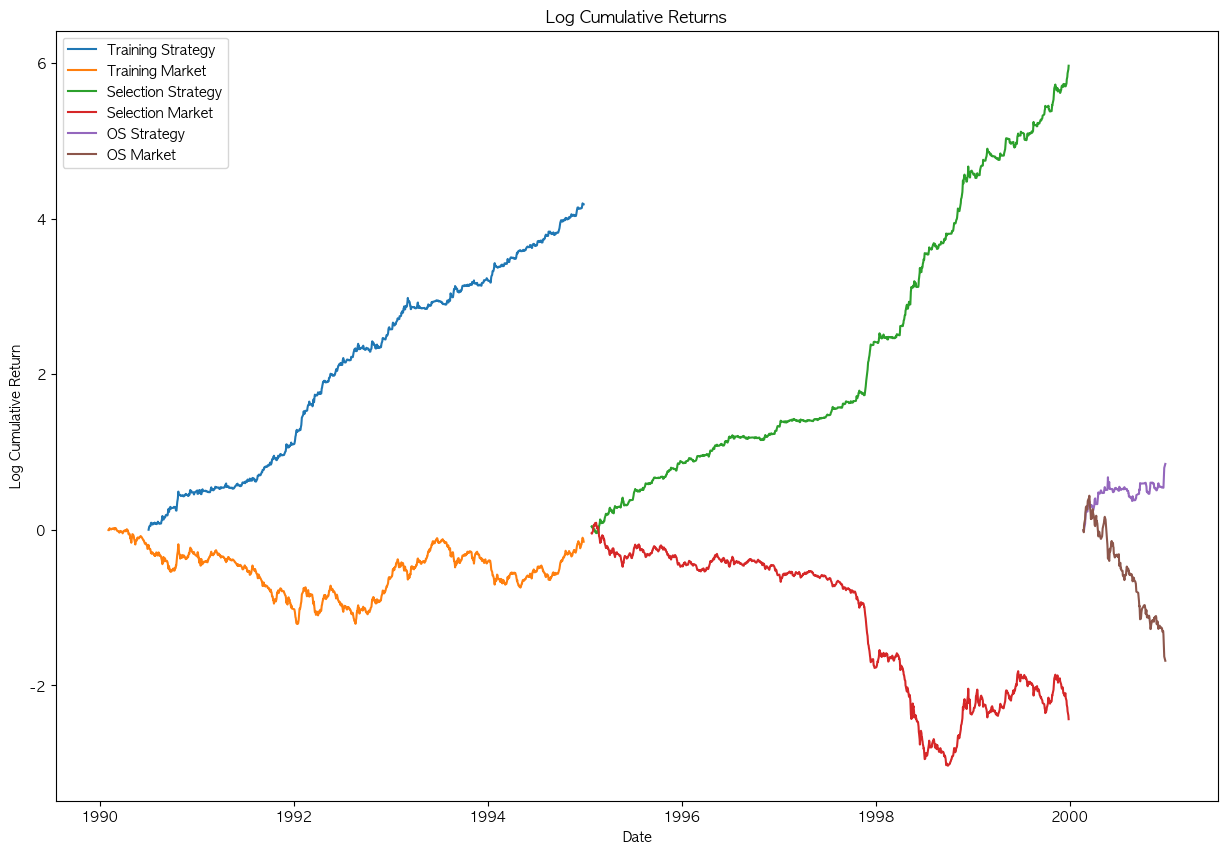

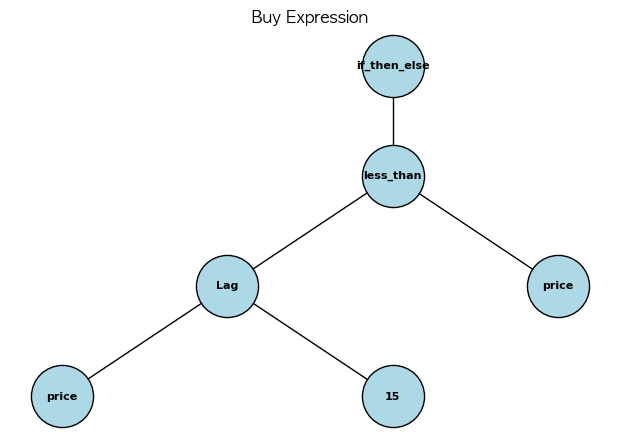

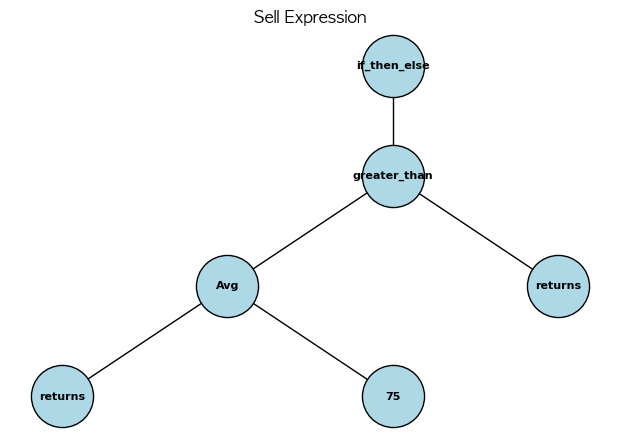

,alpha,4factor_alpha,fitness,t_stat,betc,sharpe_ratio,total_return,strategy_returns,holding_returns,holding_total_return,buy_signal,sell_signal,buy_num,sell_num,hold_rf_num,buy_expr,sell_expr
0,2.573041,0.942429,2.573041,3.446847,0.008172,2.302021,1.331393,Date 2000-02-22 -0.004346 2000-02-23 0.00...,Date 2000-02-22 -0.004346 2000-02-23 -0.02...,-0.81422,Date 2000-02-21 1 2000-02-22 1 2000-02-2...,Date 2000-02-21 0 2000-02-22 1 2000-02-2...,14,39,48,"[<deap.gp.Primitive object at 0x50ee9acf0>, <d...","[<deap.gp.Primitive object at 0x50ee9acf0>, <d..."
1,3.400821,1.770209,3.400821,4.390963,0.016726,3.624929,3.524425,Date 2000-02-22 0.000339 2000-02-23 0.02...,Date 2000-02-22 -0.004346 2000-02-23 -0.02...,-0.81422,Date 2000-02-21 1 2000-02-22 0 2000-02-2...,Date 2000-02-21 1.0 2000-02-22 1.0 2000-...,2,44,42,"[<deap.gp.Primitive object at 0x50ee9acf0>, <d...","[<deap.gp.Primitive object at 0x50f4584a0>, <d..."
2,3.400821,1.770209,3.400821,4.390963,0.016726,3.624929,3.524425,Date 2000-02-22 0.000339 2000-02-23 0.02...,Date 2000-02-22 -0.004346 2000-02-23 -0.02...,-0.81422,Date 2000-02-21 1 2000-02-22 0 2000-02-2...,Date 2000-02-21 1.0 2000-02-22 1.0 2000-...,2,44,42,"[<deap.gp.Primitive object at 0x50ee9acf0>, <d...","[<deap.gp.Primitive object at 0x50f4584a0>, <d..."
3,3.349702,1.719091,3.349702,3.958558,0.015600,3.656015,3.154188,Date 2000-02-22 -0.004346 2000-02-23 0.00...,Date 2000-02-22 -0.004346 2000-02-23 -0.02...,-0.81422,Date 2000-02-21 1 2000-02-22 1 2000-02-2...,Date 2000-02-21 0 2000-02-22 1 2000-02-2...,10,37,45,"[<deap.gp.Primitive object at 0x50ee9acf0>, <d...","[<deap.gp.Primitive object at 0x50ee9acf0>, <d..."
4,3.578398,1.947786,3.578398,4.382266,0.022692,4.430982,4.503011,Date 2000-02-22 -0.004346 2000-02-23 0.00...,Date 2000-02-22 -0.004346 2000-02-23 -0.02...,-0.81422,Date 2000-02-21 1.0 2000-02-22 0.0 2000-...,Date 2000-02-21 0.0 2000-02-22 0.0 2000-...,5,34,38,"[<deap.gp.Primitive object at 0x50f4584a0>, <d...","[<deap.gp.Primitive object at 0x50f4584a0>, <d..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.782316,0.151704,-inf,4.504844,-0.000551,-0.060735,-0.047884,Date 2000-02-22 -0.004346 2000-02-23 -0.02...,Date 2000-02-22 -0.004346 2000-02-23 -0.02...,-0.81422,Date 2000-02-21 1 2000-02-22 1 2000-02-2...,Date 2000-02-21 0 2000-02-22 0 2000-02-2...,45,0,45,"[<deap.gp.Primitive object at 0x50ee9acf0>, <d...","[<deap.gp.Primitive object at 0x50ee9acf0>, <d..."
96,2.398343,0.767731,2.398343,3.990902,0.031459,3.293009,1.038885,Date 2000-02-22 0.000339 2000-02-23 0.00...,Date 2000-02-22 -0.004346 2000-02-23 -0.02...,-0.81422,Date 2000-02-21 1.0 2000-02-22 1.0 2000-...,Date 2000-02-21 1.0 2000-02-22 1.0 2000-...,0,12,11,"[<deap.gp.Primitive object at 0x50f4584a0>, <d...","[<deap.gp.Primitive object at 0x50f4584a0>, <d..."
97,3.407173,1.776561,3.407173,4.349219,0.049201,3.233291,3.879113,Date 2000-02-22 0.000339 2000-02-23 0.02...,Date 2000-02-22 -0.004346 2000-02-23 -0.02...,-0.81422,Date 2000-02-21 1.0 2000-02-22 0.0 2000-...,Date 2000-02-21 1.0 2000-02-22 1.0 2000-...,0,17,16,"[<deap.gp.Primitive object at 0x50f4584a0>, <d...","[<deap.gp.Primitive object at 0x50f45bec0>, <d..."
98,1.857407,0.226795,1.857407,3.961197,0.004958,0.448014,0.154234,Date 2000-02-22 -0.004346 2000-02-23 -0.02...,Date 2000-02-22 -0.004346 2000-02-23 -0.02...,-0.81422,Date 2000-02-21 1 2000-02-22 1 2000-02-2...,Date 2000-02-21 0.0 2000-02-22 0.0 2000-...,15,0,15,"[<deap.gp.Primitive object at 0x50ee9acf0>, <d...","[<deap.gp.Primitive object at 0x50f45bec0>, <d..."


In [444]:
run('1990', 'Decile_10', 100, 5, PRINT_ON =True)

Training period: 2014-01-02 00:00:00 to 2018-12-28 00:00:00
Selection period: 2019-01-02 00:00:00 to 2023-12-28 00:00:00
OS period: 2024-01-02 00:00:00 to 2024-08-30 00:00:00

Total years used: 11
Primitives by type:
Type <class 'pandas.core.series.Series'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than', 'Filter', 'Avg', 'Max', 'Min', 'Median', 'Lag', 'Volatility', 'RSI']
Type <class '__main__.LogicalSeries'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than']
Type <class 'int'>: ['get_int_constant']
Type <class 'float'>: []
Terminals by type:
Type <class 'pandas.core.series.Series'>: ['ARG0', 'ARG1', 'price', 'returns']
Type <class '__main__.LogicalSeries'>: []
Type <class 'int'>: []
Type <class 'float'>: []
Decile_1
-- 세대 0 --
Unique fitness numbers: 6
-- 세대 1 --
Unique fitness numbers: 6
상위 5 개체:
1. Buy: or_op(greater_than(Max(returns, 34), price), less_than(Min(price, 5), price)), Sell: and_op(greater_than(Avg(returns, 98), returns), less_than(RSI(pr

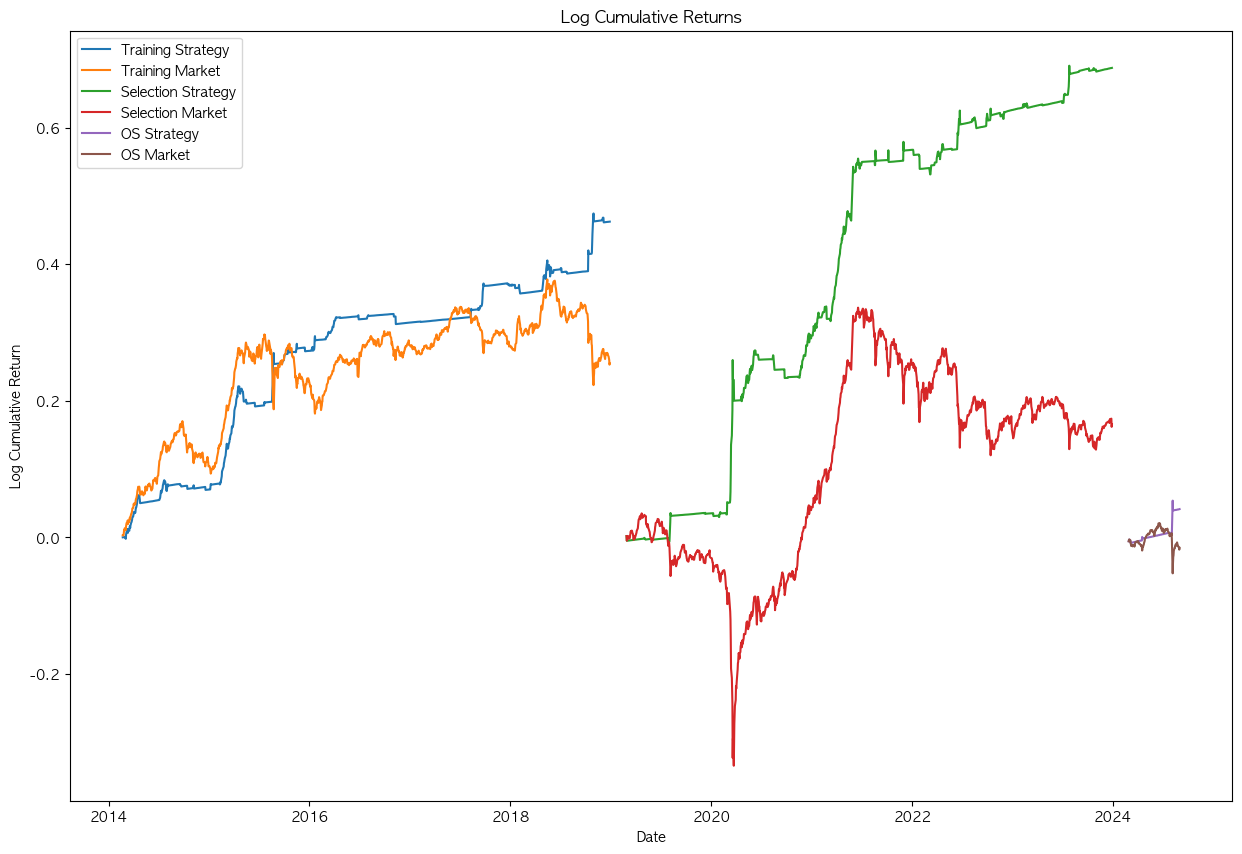

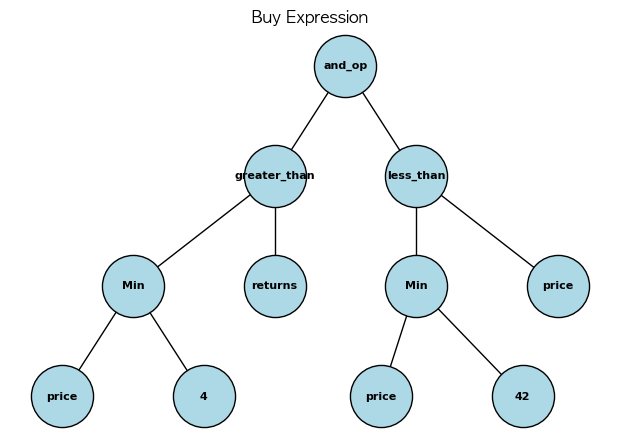

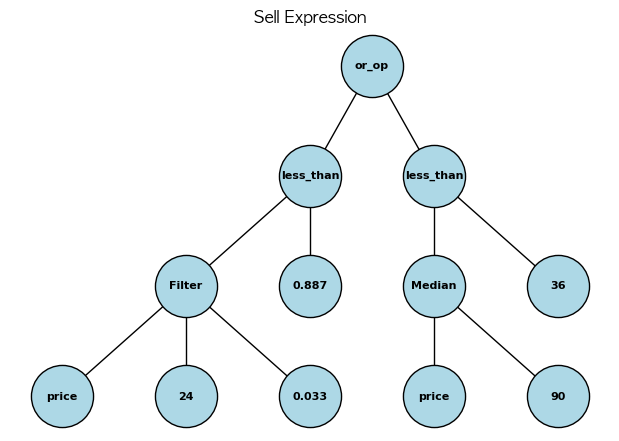

,alpha,4factor_alpha,fitness,t_stat,betc,sharpe_ratio,total_return,strategy_returns,holding_returns,holding_total_return,buy_signal,sell_signal
0,-0.069571,-0.034185,-inf,-0.907958,0.005938,0.708744,0.042317,Date 2024-02-27 -0.005684 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
1,-0.121399,-0.086013,-inf,-1.635011,0.000647,0.027915,0.016292,Date 2024-02-27 0.000135 2024-02-28 -0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1.0 2024-02-27 0.0 2024-...,Date 2024-02-26 1 2024-02-27 1 2024-02-2...
2,-0.002329,0.033056,-inf,-0.045483,0.001057,1.197974,0.032209,Date 2024-02-27 0.000135 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
3,-0.013446,0.021940,-inf,-0.267723,0.000878,0.609309,0.024872,Date 2024-02-27 0.000135 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 0 2024-02-27 0 2024-02-2...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
4,-0.090897,-0.055511,-inf,-1.765864,-0.002291,-2.027086,-0.006858,Date 2024-02-27 -0.005684 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
5,0.031616,0.067001,-inf,0.624816,0.001512,1.647887,0.046375,Date 2024-02-27 0.000135 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
6,-0.049076,-0.013690,-inf,-0.655036,0.002257,0.990552,0.053212,Date 2024-02-27 0.000135 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1 2024-02-27 1 2024-02-2...,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...
7,-0.005951,0.029435,-inf,-0.129734,0.002284,1.312656,0.032451,Date 2024-02-27 0.000135 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 0 2024-02-27 0 2024-02-2...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
8,-0.069081,-0.033695,-inf,-1.551534,-0.000254,-1.657194,-0.003039,Date 2024-02-27 -0.005684 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1 2024-02-27 1 2024-02-2...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
9,-0.027721,0.007665,-inf,-0.557588,0.000942,0.043899,0.017097,Date 2024-02-27 0.000135 2024-02-28 -0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...,Date 2024-02-26 0 2024-02-27 1 2024-02-2...


In [429]:
run('2014', 'Decile_1', 100, 5, PRINT_ON =True)

Training period: 2014-01-02 00:00:00 to 2018-12-28 00:00:00
Selection period: 2019-01-02 00:00:00 to 2023-12-28 00:00:00
OS period: 2024-01-02 00:00:00 to 2024-08-30 00:00:00

Total years used: 11
Primitives by type:
Type <class 'pandas.core.series.Series'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than', 'Filter', 'Avg', 'Max', 'Min', 'Median', 'Lag', 'Volatility', 'RSI']
Type <class '__main__.LogicalSeries'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than']
Type <class 'int'>: ['get_int_constant']
Type <class 'float'>: []
Terminals by type:
Type <class 'pandas.core.series.Series'>: ['ARG0', 'ARG1', 'price', 'returns']
Type <class '__main__.LogicalSeries'>: []
Type <class 'int'>: []
Type <class 'float'>: []
Decile_10
-- 세대 0 --
Unique fitness numbers: 44
-- 세대 1 --
Unique fitness numbers: 98
상위 5 개체:
1. Training Fitness: 0.518, Selection Fitness: 0.776, OS Fitness: 0.502, OS Alpha: 0.502, OS 4Factor Alpha: 0.108 Buy: if_then_else(less_than(RSI(returns,

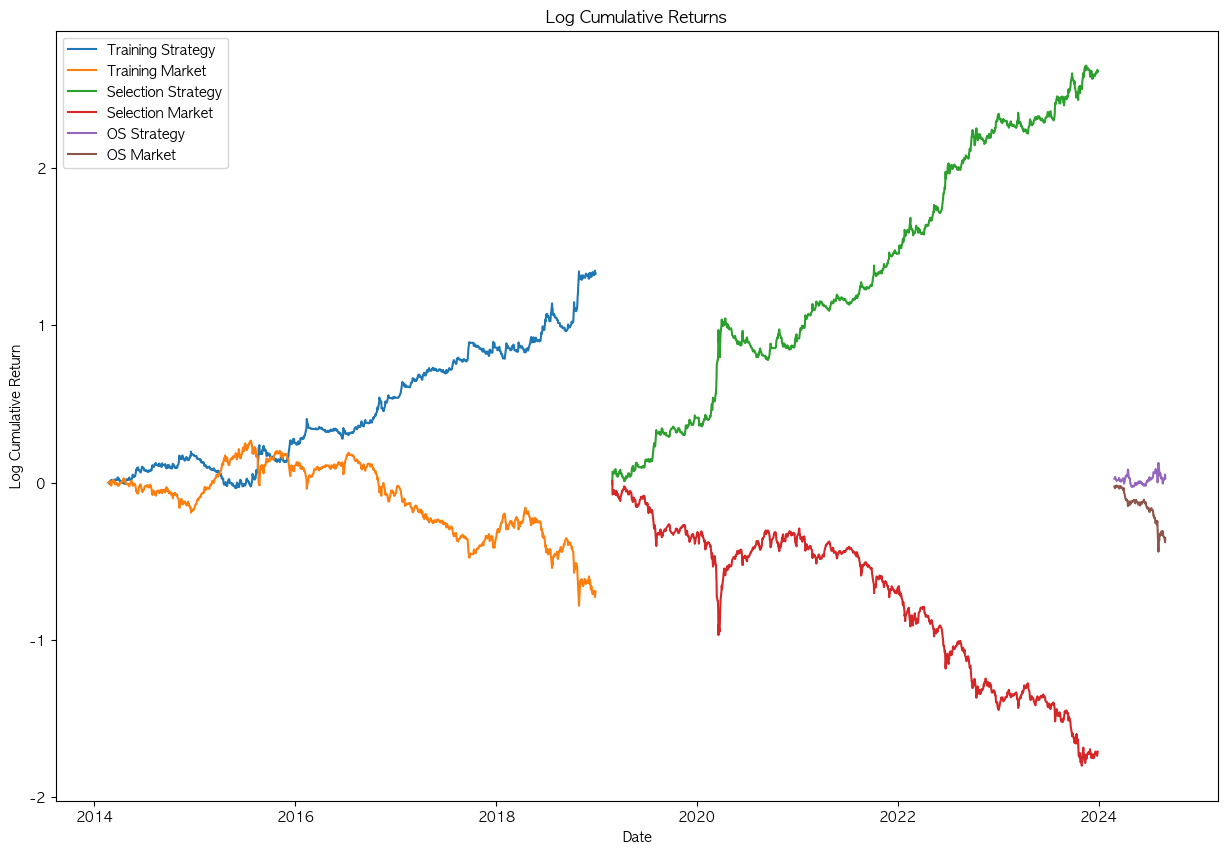

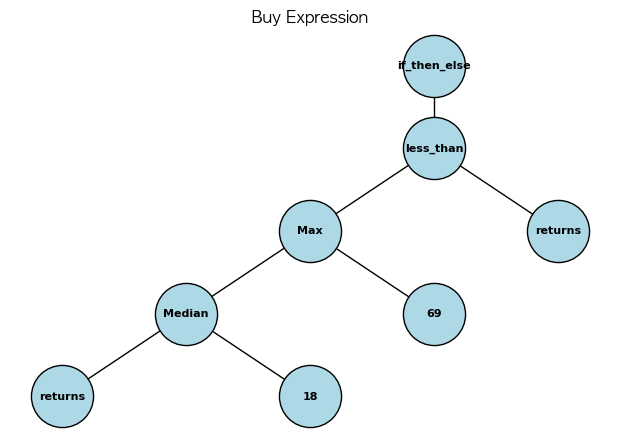

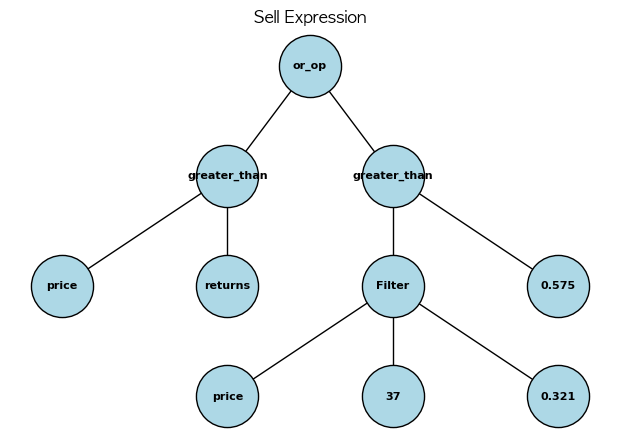

,alpha,4factor_alpha,fitness,t_stat,betc,sharpe_ratio,total_return,strategy_returns,holding_returns,holding_total_return,buy_signal,sell_signal
0,0.127359,-0.267134,-inf,0.398214,0.000318,0.206596,0.027085,Date 2024-02-27 0.024252 2024-02-28 -0.00...,Date 2024-02-27 -0.024252 2024-02-28 0.00...,-0.299496,Date 2024-02-26 0 2024-02-27 0 2024-02-2...,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...
1,0.112918,-0.281575,-inf,0.356693,0.000210,0.139260,0.017369,Date 2024-02-27 0.024252 2024-02-28 -0.00...,Date 2024-02-27 -0.024252 2024-02-28 0.00...,-0.299496,Date 2024-02-26 0 2024-02-27 0 2024-02-2...,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...
2,0.112918,-0.281575,-inf,0.356693,0.000210,0.139260,0.017369,Date 2024-02-27 0.024252 2024-02-28 -0.00...,Date 2024-02-27 -0.024252 2024-02-28 0.00...,-0.299496,Date 2024-02-26 0 2024-02-27 0 2024-02-2...,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...
3,0.203681,-0.190812,-inf,0.668396,0.000785,0.475730,0.066428,Date 2024-02-27 0.024252 2024-02-28 -0.00...,Date 2024-02-27 -0.024252 2024-02-28 0.00...,-0.299496,Date 2024-02-26 0 2024-02-27 0 2024-02-2...,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...
4,0.178809,-0.215684,-inf,0.562933,0.000639,0.389143,0.053744,Date 2024-02-27 0.024252 2024-02-28 -0.00...,Date 2024-02-27 -0.024252 2024-02-28 0.00...,-0.299496,Date 2024-02-26 0 2024-02-27 0 2024-02-2...,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...
...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.446525,0.052031,0.446525,1.761204,0.005501,1.406870,0.205068,Date 2024-02-27 0.024252 2024-02-28 -0.00...,Date 2024-02-27 -0.024252 2024-02-28 0.00...,-0.299496,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...,Date 2024-02-26 1 2024-02-27 1 2024-02-2...
496,0.328603,-0.065890,-inf,1.078226,0.002251,0.922685,0.134204,Date 2024-02-27 0.024252 2024-02-28 -0.00...,Date 2024-02-27 -0.024252 2024-02-28 0.00...,-0.299496,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...
497,0.494889,0.100396,0.494889,2.124904,0.003550,1.559375,0.219508,Date 2024-02-27 0.024252 2024-02-28 -0.00...,Date 2024-02-27 -0.024252 2024-02-28 0.00...,-0.299496,Date 2024-02-26 0 2024-02-27 0 2024-02-2...,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...
498,0.202137,-0.192356,-inf,1.276727,-0.003048,-1.653062,-0.076299,Date 2024-02-27 0.000135 2024-02-28 0.00...,Date 2024-02-27 -0.024252 2024-02-28 0.00...,-0.299496,Date 2024-02-26 1 2024-02-27 1 2024-02-2...,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...


In [435]:
run('2014', 'Decile_10', 500, 20, PRINT_ON =True)

Training period: 2014-01-02 00:00:00 to 2018-12-28 00:00:00
Selection period: 2019-01-02 00:00:00 to 2023-12-28 00:00:00
OS period: 2024-01-02 00:00:00 to 2024-08-30 00:00:00

Total years used: 11
Primitives by type:
Type <class 'pandas.core.series.Series'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than', 'Filter', 'Avg', 'Max', 'Min', 'Median', 'Lag', 'Volatility', 'RSI']
Type <class '__main__.LogicalSeries'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than']
Type <class 'int'>: ['get_int_constant']
Type <class 'float'>: []
Terminals by type:
Type <class 'pandas.core.series.Series'>: ['ARG0', 'ARG1', 'price', 'returns']
Type <class '__main__.LogicalSeries'>: []
Type <class 'int'>: []
Type <class 'float'>: []
Decile_1
-- 세대 0 --
Unique fitness numbers: 7
-- 세대 1 --
Unique fitness numbers: 19
상위 5 개체:
1. Training Fitness: 0.085, Selection Fitness: 0.116, OS Fitness: -inf, OS Alpha: 0.032, OS 4Factor Alpha: 0.067 Buy: if_then_else(less_than(Min(price, 6), 

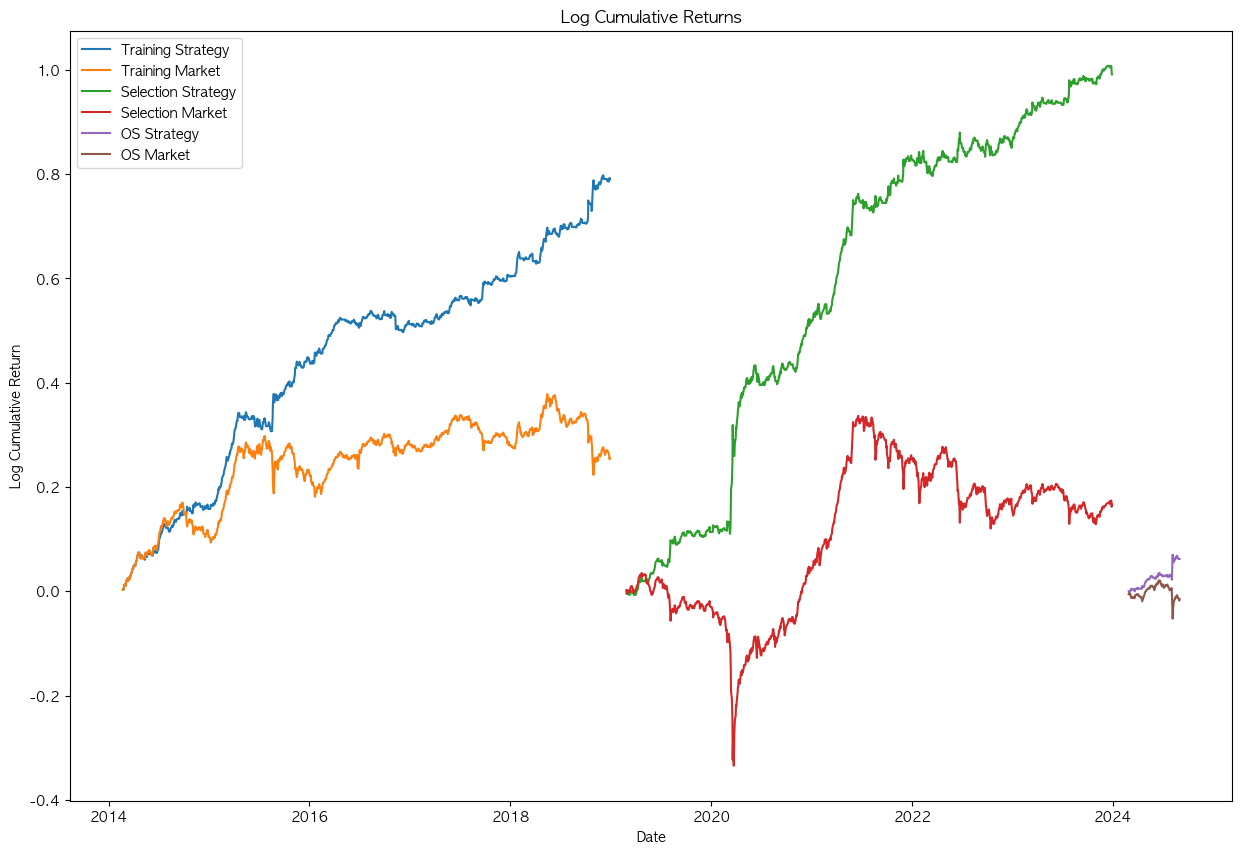

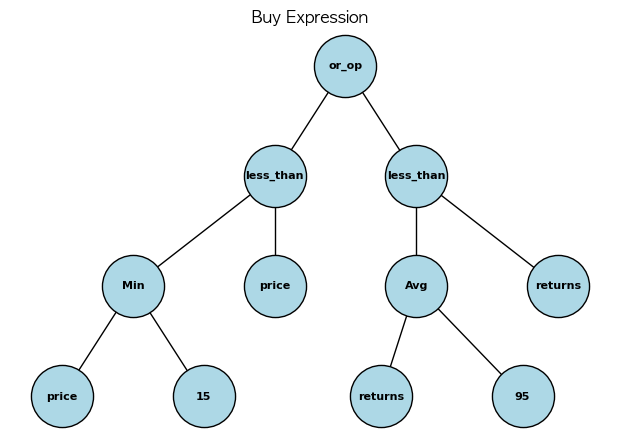

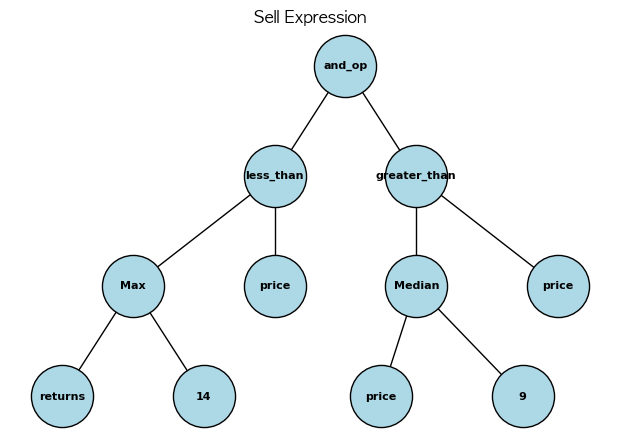

,alpha,4factor_alpha,fitness,t_stat,betc,sharpe_ratio,total_return,strategy_returns,holding_returns,holding_total_return,buy_signal,sell_signal
0,-0.026680,0.008706,-inf,-0.286287,0.001828,1.209878,0.064073,Date 2024-02-27 0.000135 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...
1,-0.066074,-0.030689,-inf,-0.752878,0.001999,0.627982,0.040759,Date 2024-02-27 -0.005684 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
2,-0.075209,-0.039823,-inf,-0.858025,0.001075,0.545996,0.037199,Date 2024-02-27 -0.005684 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
3,-0.035497,-0.000111,-inf,-0.430369,0.002330,1.041626,0.057445,Date 2024-02-27 -0.005684 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
4,-0.038493,-0.003107,-inf,-0.462163,0.003450,1.030990,0.056659,Date 2024-02-27 -0.005684 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.136739,-0.101354,-inf,-1.568103,-0.002293,-2.189483,-0.027173,Date 2024-02-27 -0.005684 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1 2024-02-27 1 2024-02-2...,Date 2024-02-26 0 2024-02-27 0 2024-02-2...
496,-0.063254,-0.027868,-inf,-1.031614,-0.003069,-1.474564,-0.039177,Date 2024-02-27 -0.005684 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1.0 2024-02-27 1.0 2024-...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
497,-0.115025,-0.079639,-inf,-1.301731,0.001299,0.078417,0.018347,Date 2024-02-27 -0.005684 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1 2024-02-27 1 2024-02-2...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...
498,-0.143794,-0.108409,-inf,-1.597840,0.000211,-0.251116,0.005079,Date 2024-02-27 -0.005684 2024-02-28 0.00...,Date 2024-02-27 -0.005684 2024-02-28 0.00...,-0.015167,Date 2024-02-26 1.0 2024-02-27 0.0 2024-...,Date 2024-02-26 0.0 2024-02-27 0.0 2024-...


In [436]:
run('2014', 'Decile_1', 500, 20, PRINT_ON =True)

In [455]:
def run_simulation(decile_price_df, factor_df, start_years, population_size=500, generations=20, n_simulations=1):
    results = []

    for start_year in tqdm(start_years, desc="Processing years"):
        for decile in tqdm(decile_price_df.columns, desc="Processing deciles", leave=False):
            for sim in tqdm(range(n_simulations), desc="Running simulations", leave=False):
                # GeneticProgrammingTrader 인스턴스 생성
                print(f"{start_year} / {len(start_years)}, {decile}/{len(decile_price_df.columns)}, {sim}/{n_simulations}")
                start_year = str(start_year)
                gp_trader = GeneticProgrammingTrader(decile_price_df[[decile]], factor_df, decile_returns_df, decile, start_year=start_year)
                
                # 초기 population의 alpha 수집
                initial_population = gp_trader.create_primary_set(population_size)
                initial_results = gp_trader.evaluate_final_results(initial_population)#[ind.fitness.values[0] for ind in initial_population if ind.fitness.valid]
                initial_alphas = list(initial_results['4factor_alpha'])
                initial_buy_expr = list(initial_results['buy_expr'])
                initial_sell_expr = list(initial_results['sell_expr'])
                # 유전 알고리즘 실행
                final_population, final_result = gp_trader.run_evolution(population_size, generations)
                final_alphas = list(final_result['4factor_alpha'])
                final_betc = list(final_result['betc'])
                final_sharpe_ratio = list(final_result['sharpe_ratio'])
                final_buy_num = list(final_result['buy_num'])
                final_sell_num = list(final_result['sell_num'])
                final_hold_rf_num = list(final_result['hold_rf_num'])
                final_buy_expr = list(final_result['buy_expr'])
                final_sell_expr = list(final_result['sell_expr'])
                final_strategy_returns = list(final_result['strategy_returns'])
                # 최종 population의 alpha 수집 및 유효하지 않은 전략 제거
                #final_alphas = [ind.fitness.values[0] for ind in final_population if ind.fitness.valid and ind.fitness.values[0] != -np.inf]
                
                # 최고 개체에 대한 out-of-sample 평가
                #os_result = gp_trader.evaluate_strategy(gp_trader.best_individual, gp_trader.out_sample_df_padded, gp_trader.out_sample_factors, "OS")
                
                results.append({
                    'start_year': start_year,
                    'decile': decile,
                    'simulation': sim + 1,
                    'initial_alphas': initial_alphas,
                    'final_alphas': final_alphas,
                    'initial_set_size': len(initial_alphas),
                    'final_set_size': len(final_alphas),
                    'final_betc': final_betc,
                    'final_sharpe_ratio': final_sharpe_ratio,
                    'final_buy_num': final_buy_num,
                    'final_sell_num': final_sell_num,
                    'final_hold_rf_num': final_hold_rf_num,
                    'final_strategy_returns': final_strategy_returns,       
                    'initial_buy_expr': initial_buy_expr,
                    'initial_sell_expr': initial_sell_expr,         
                    'final_buy_expr': final_buy_expr,
                    'final_sell_expr': final_sell_expr
                    
                    # 'best_training_alpha': gp_trader.best_individual.fitness.values[0],
                    # 'best_os_alpha': os_result['alpha'] if os_result else None,
                    # 'best_os_tstat': os_result['t_stat'] if os_result else None,
                    # 'best_os_sharpe': os_result['sharpe_ratio'] if os_result else None,
                    # 'best_os_total_return': os_result['total_return'] if os_result else None
                })
    
    return pd.DataFrame(results)

# 실행 예시
#start_years = range(1990, 2015)
start_years = range(1990, 2000) # 1990 ~ 1999 까지
#start_years = range(1990, 1991)
#start_years = range(1990, 1993)
simulation_results = run_simulation(decile_price_df, factor_df, start_years, population_size=500, generations=20, n_simulations=1)

# 결과 저장
simulation_results.to_csv('gp_trading_simulation_results.csv', index=False)

# 결과 요약
print(simulation_results.describe())

# 그래프로 결과 시각화


# plt.figure(figsize=(12, 6))
# plt.scatter(simulation_results['start_year'], simulation_results['best_os_alpha'])
# plt.title('Best Out-of-Sample Alpha by Start Year')
# plt.xlabel('Start Year')
# plt.ylabel('Best OS Alpha')
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.boxplot([simulation_results[simulation_results['decile'] == d]['best_os_alpha'] for d in decile_price_df.columns])
# plt.title('Distribution of Best Out-of-Sample Alpha by Decile')
# plt.xlabel('Decile')
# plt.ylabel('Best OS Alpha')
# plt.xticks(range(1, len(decile_price_df.columns) + 1), decile_price_df.columns)
# plt.show()

Processing years:   0%|          | 0/10 [00:00<?, ?it/s]


1990 / 10, Decile_1/10, 0/1
Training period: 1990-01-03 00:00:00 to 1994-12-28 00:00:00
Selection period: 1995-01-03 00:00:00 to 1999-12-28 00:00:00
OS period: 2000-01-04 00:00:00 to 2000-12-26 00:00:00

Total years used: 11


1990 / 10, Decile_2/10, 0/1
Training period: 1990-01-03 00:00:00 to 1994-12-28 00:00:00
Selection period: 1995-01-03 00:00:00 to 1999-12-28 00:00:00
OS period: 2000-01-04 00:00:00 to 2000-12-26 00:00:00

Total years used: 11



Processing years:   0%|          | 0/10 [08:42<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def safe_mean(x):
    if isinstance(x, str):
        # If it's a string, evaluate it as a list
        x = eval(x)
    return np.mean(x)
# Calculate mean of initial_alphas and final_alphas
simulation_results['mean_initial_alpha'] = simulation_results['initial_alphas'].apply(safe_mean)# * 252
simulation_results['mean_final_alpha'] = simulation_results['final_alphas'].apply(safe_mean)# * 252
try:
    simulation_results['start_year'] = pd.to_numeric(simulation_results['start_year'], errors='coerce')
    simulation_results['os_year'] = simulation_results['start_year'] + 10
except Exception as e:
    print(f"Error converting start_year to numeric: {e}")
    print("Displaying the first few rows of start_year column:")
    print(simulation_results['start_year'].head())
    raise# Display the first few rows of the updated dataframe
simulation_results

,start_year,decile,simulation,initial_alphas,final_alphas,initial_set_size,final_set_size,final_betc,final_sharpe_ratio,final_buy_num,final_sell_num,final_hold_rf_num,final_strategy_returns,initial_buy_expr,initial_sell_expr,final_buy_expr,final_sell_expr,mean_initial_alpha,mean_final_alpha,os_year
0,1990,Decile_1,1,"[-0.2780013257426836, 0.30350147585702303, 0.0...","[0.32344212542029166, 0.17315328347427786, -0....",100,42,"[0.0029441351568386676, 0.002326623344433676, ...","[1.6347697763583688, 1.0612840027786543, -1.64...","[34, 11, 13, 10, 9, 17, 7, 3, 20, 0, 10, 0, 0,...","[30, 39, 15, 1, 49, 0, 45, 16, 0, 9, 0, 14, 12...","[48, 45, 22, 11, 48, 17, 44, 18, 20, 8, 10, 13...","[[0.0023411879949279957, -0.05423496657153093,...","[if_then_else(less_than(Min(price, 93), 30)), ...","[and_op(less_than(Volatility(returns, 32), 62)...","[if_then_else(less_than(Median(price, 12), pri...","[and_op(greater_than(Filter(price, 42, 0.477),...",-0.052896,0.005892,2000
1,1990,Decile_2,1,"[0.15588589882154885, -0.0456040629948707, -0....","[0.5939119634638997, 0.6434542597399764, 0.652...",100,28,"[0.008306639246006498, 0.009048951601453137, 0...","[2.559363583079526, 2.8422978095266687, 2.8719...","[0, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 26, 0, 0, 8...","[41, 41, 41, 43, 43, 34, 47, 0, 4, 5, 5, 0, 6,...","[40, 40, 40, 42, 42, 33, 47, 41, 3, 4, 4, 26, ...","[[0.0003209305853030253, 0.0003380952380952381...","[and_op(less_than(Median(returns, 40), 64), gr...","[if_then_else(greater_than(Max(price, 10), 0.5...","[and_op(greater_than(Lag(price, 37), 0.896), l...","[if_then_else(less_than(RSI(returns, 92), 68))...",-0.020286,0.126002,2000
2,1990,Decile_3,1,"[0.36694163589020495, 0.0, 0.0, -0.29391753049...","[0.2681446824113957, 0.989778081819984, 0.3981...",100,38,"[0.0034078159282420195, 0.01306578272346881, 0...","[1.2111758091297364, 3.703459117805037, 1.7081...","[5, 0, 0, 4, 0, 0, 39, 39, 0, 0, 0, 0, 0, 14, ...","[46, 40, 16, 22, 46, 10, 0, 0, 4, 40, 47, 8, 2...","[44, 39, 15, 23, 45, 9, 39, 39, 3, 40, 46, 7, ...","[[-0.010314164998426412, 0.0003380952380952381...","[if_then_else(greater_than(Avg(price, 85), 24)...","[if_then_else(greater_than(Median(returns, 8),...","[and_op(less_than(Avg(returns, 11), returns), ...","[and_op(greater_than(Max(returns, 36), returns...",-0.050158,0.146052,2000
3,1990,Decile_4,1,"[0.475040176985633, 0.9925809318973231, 0.4750...","[0.9097894252412644, 0.28933385280811713, 0.41...",100,24,"[0.01043024578506957, 0.0018163175670140586, 0...","[3.2387116972474934, 0.4979181624880807, 0.904...","[0, 42, 46, 46, 49, 1, 4, 4, 0, 4, 0, 7, 0, 1,...","[46, 0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 11, 0, ...","[45, 42, 46, 46, 49, 1, 4, 4, 31, 4, 0, 7, 10,...","[[-0.004974407564769301, 0.0003380952380952381...","[and_op(greater_than(Min(price, 94), 64), less...","[and_op(greater_than(Avg(price, 21), returns),...","[and_op(less_than(Median(price, 92), 100), gre...","[if_then_else(greater_than(Avg(returns, 90), r...",0.032887,0.071892,2000
4,1990,Decile_5,1,"[-0.7041479721913335, 0.0, 0.6520128134505637,...","[1.1574442659808155, 1.0552756476297371, 1.232...",100,39,"[0.014028595285685785, 0.010923575345787029, 0...","[2.9494677234852014, 3.204170710898993, 3.7190...","[16, 0, 0, 0, 45, 0, 44, 47, 0, 45, 46, 0, 36,...","[24, 48, 46, 47, 0, 37, 0, 0, 65, 0, 0, 7, 8, ...","[25, 47, 45, 46, 45, 36, 44, 47, 65, 45, 46, 6...","[[-0.006741695807754411, -0.05470261461144221,...","[and_op(greater_than(Volatility(price, 31), re...","[and_op(greater_than(Lag(price, 48), returns),...","[or_op(greater_than(Min(returns, 17), 0.685), ...","[and_op(greater_than(Avg(price, 49), 70), grea...",-0.117429,0.363692,2000
5,1990,Decile_6,1,"[-0.7023529360274325, -0.5283899470198635, 0.0...","[1.383172328548709, 1.2278871413664236, 1.1966...",100,51,"[0.015411611160800698, 0.014858226668416963, 0...","[3.601441339152094, 3.8469819119774398, 3.7086...","[9, 0, 0, 0, 41, 0, 40, 42, 5, 24, 3, 42, 0, 2...","[33, 41, 42, 41, 3, 42, 0, 0, 17, 0, 19, 0, 45..."

In [ ]:
len(set(simulation_results['final_alphas'][0]))

26

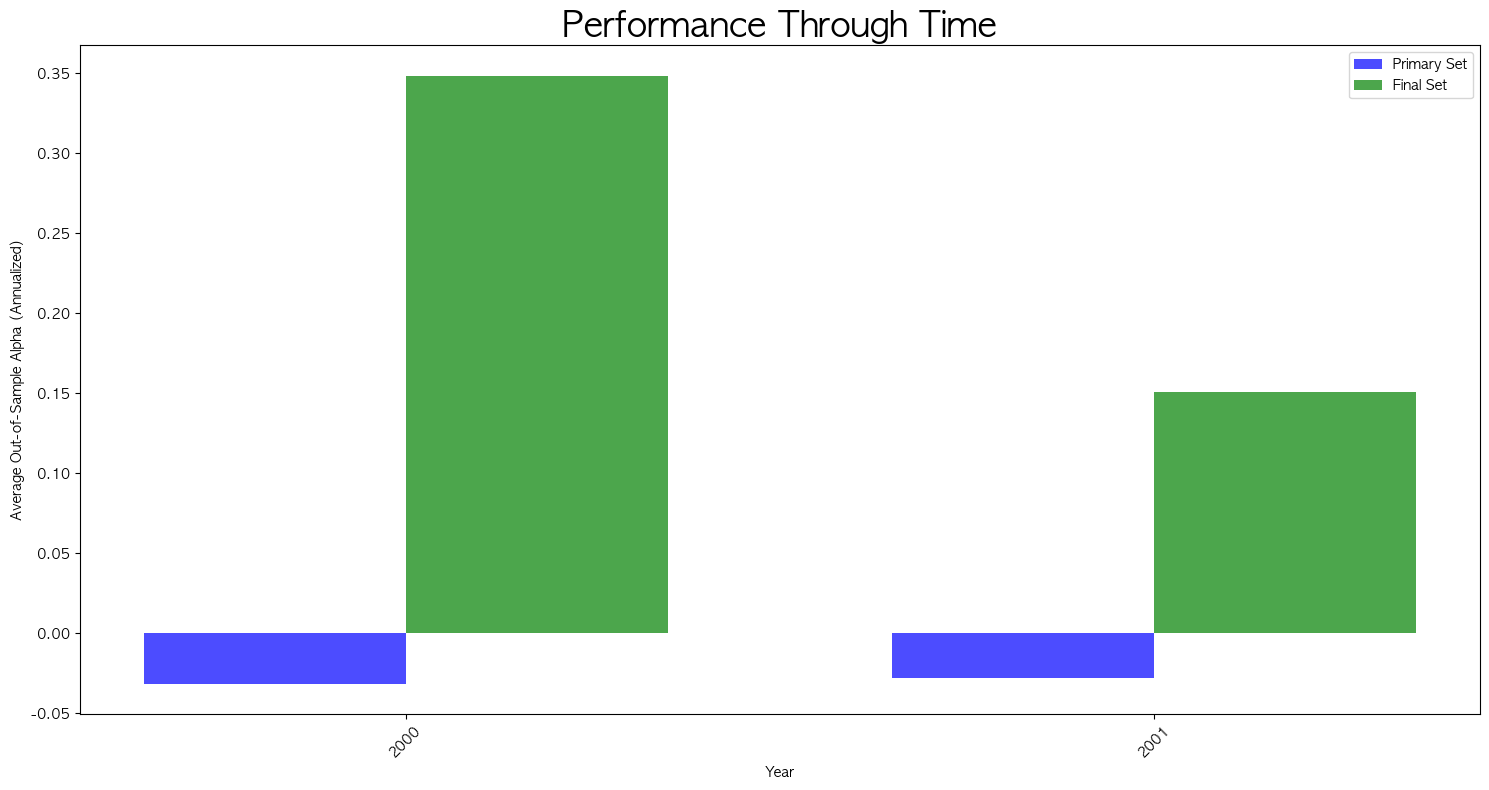

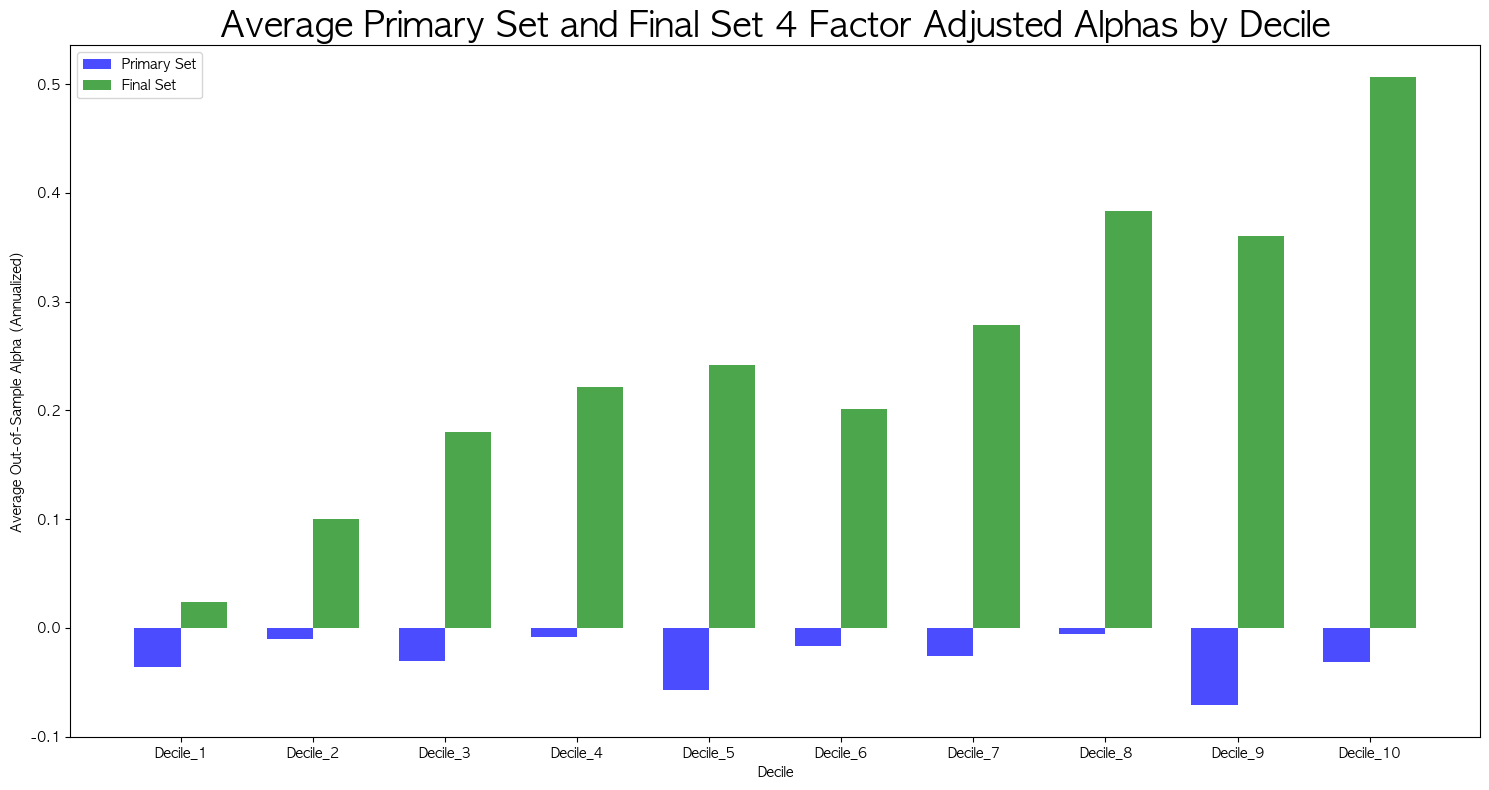

In [ ]:
# Assuming the dataframe is called 'simulation_results'

# Group by os_year and calculate mean for each alpha
yearly_alphas = simulation_results.groupby('os_year')[['mean_initial_alpha', 'mean_final_alpha']].mean().reset_index()

# Create the year-wise plot
plt.figure(figsize=(15, 8))
bar_width = 0.35
index = range(len(yearly_alphas))

plt.bar(index, yearly_alphas['mean_initial_alpha'], bar_width, label='Primary Set', color='blue', alpha=0.7)
plt.bar([i + bar_width for i in index], yearly_alphas['mean_final_alpha'], bar_width, label='Final Set', color='green', alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Average Out-of-Sample Alpha (Annualized)')
plt.title('Performance Through Time', fontsize = 25)
plt.xticks([i + bar_width/2 for i in index], yearly_alphas['os_year'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Group by decile and calculate mean for each alpha
decile_alphas = simulation_results.groupby('decile')[['mean_initial_alpha', 'mean_final_alpha']].mean().reset_index()

# Extract decile number and sort
decile_alphas['decile_num'] = decile_alphas['decile'].str.extract('(\d+)').astype(int)
decile_alphas = decile_alphas.sort_values('decile_num')

# Create the decile-wise plot
plt.figure(figsize=(15, 8))
index = range(len(decile_alphas))

plt.bar(index, decile_alphas['mean_initial_alpha'], bar_width, label='Primary Set', color='blue', alpha=0.7)
plt.bar([i + bar_width for i in index], decile_alphas['mean_final_alpha'], bar_width, label='Final Set', color='green', alpha=0.7)

plt.xlabel('Decile')
plt.ylabel('Average Out-of-Sample Alpha (Annualized)')
plt.title('Average Primary Set and Final Set 4 Factor Adjusted Alphas by Decile', fontsize = 25)
plt.xticks([i + bar_width/2 for i in index], decile_alphas['decile'])
plt.legend()

plt.tight_layout()
plt.show()